In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
sns.set(font_scale = 1.5)

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [4]:
def plot_autocorrs(data, buoy_id, feature, test_size, lags, alpha=0.05):
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2]))
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharey=True)
    plot_acf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'{feature} Autocorrelation')
    plot_pacf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'{feature} Partial Autocorrelation')
    plt.show()

In [5]:
def plot_diff(data, buoy_id, test_size, feature):
    fig, ax = plt.subplots(nrows=3, figsize=(15, 12))
    data[data['Spot Id'] == buoy_id][feature][:-test_size].plot(kind='line', color=['crimson'], lw=2, ax=ax[0])
    ax[0].set_title(f'{feature}')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff()[1:].plot(kind='line', color=['crimson'], lw=2, ax=ax[1])
    ax[1].set_title(f'{feature} Differenced Once')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff().diff()[2:].plot(kind='line', color=['crimson'], lw=2, ax=ax[2])
    ax[2].set_title(f'{feature} Differenced Twice')
    plt.show()

In [6]:
def make_predict(data, buoy_id, feature, order, start_p, end_p, exog_features=[]):
    endog = data[data['Spot Id'] == buoy_id][feature].reset_index(drop=True)
    if exog_features != []:
        exog = data[data['Spot Id'] == buoy_id][exog_features].reset_index(drop=True)
        
        model = sm.tsa.statespace.SARIMAX(endog=endog[:-48], exog=exog[:-48], order=order, trend='c')
        results = model.fit(maxiter=5000)
        print(results.summary())
    
        preds = results.predict(start=0, end=len(endog[:-48])+end_p, exog=exog[-49:], dynamic=False)
        ci = results.get_prediction(start=-120, end=len(endog)+end_p, exog=exog[-97:]).conf_int(alpha=0.05)
    
    else:
        model = sm.tsa.statespace.SARIMAX(endog=endog[:-48],order=order, trend='c')
        results = model.fit(maxiter=5000)
        print(results.summary())
    
        preds = results.predict(start=0, end=len(endog[:-48])+end_p, dynamic=False)
        ci = results.get_prediction(start=-120, end=len(endog)+end_p).conf_int(alpha=0.05)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    endog[-168:-end_p+1].plot(c='b', label=f'Training {feature}', lw=5, ax=ax)
    endog[-end_p:].plot(c='k', label=f'Testing {feature}', lw=5, ax=ax)
    preds[-168:].plot(c='g', ls='--', lw=2.5, label='Non-dynamical Foreacasting', ax=ax)
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:, 1], alpha=0.3)
    plt.legend(loc=[1.1, 0])
    results.plot_diagnostics(figsize=(15, 15))
    print(preds[-10:])
    plt.show()

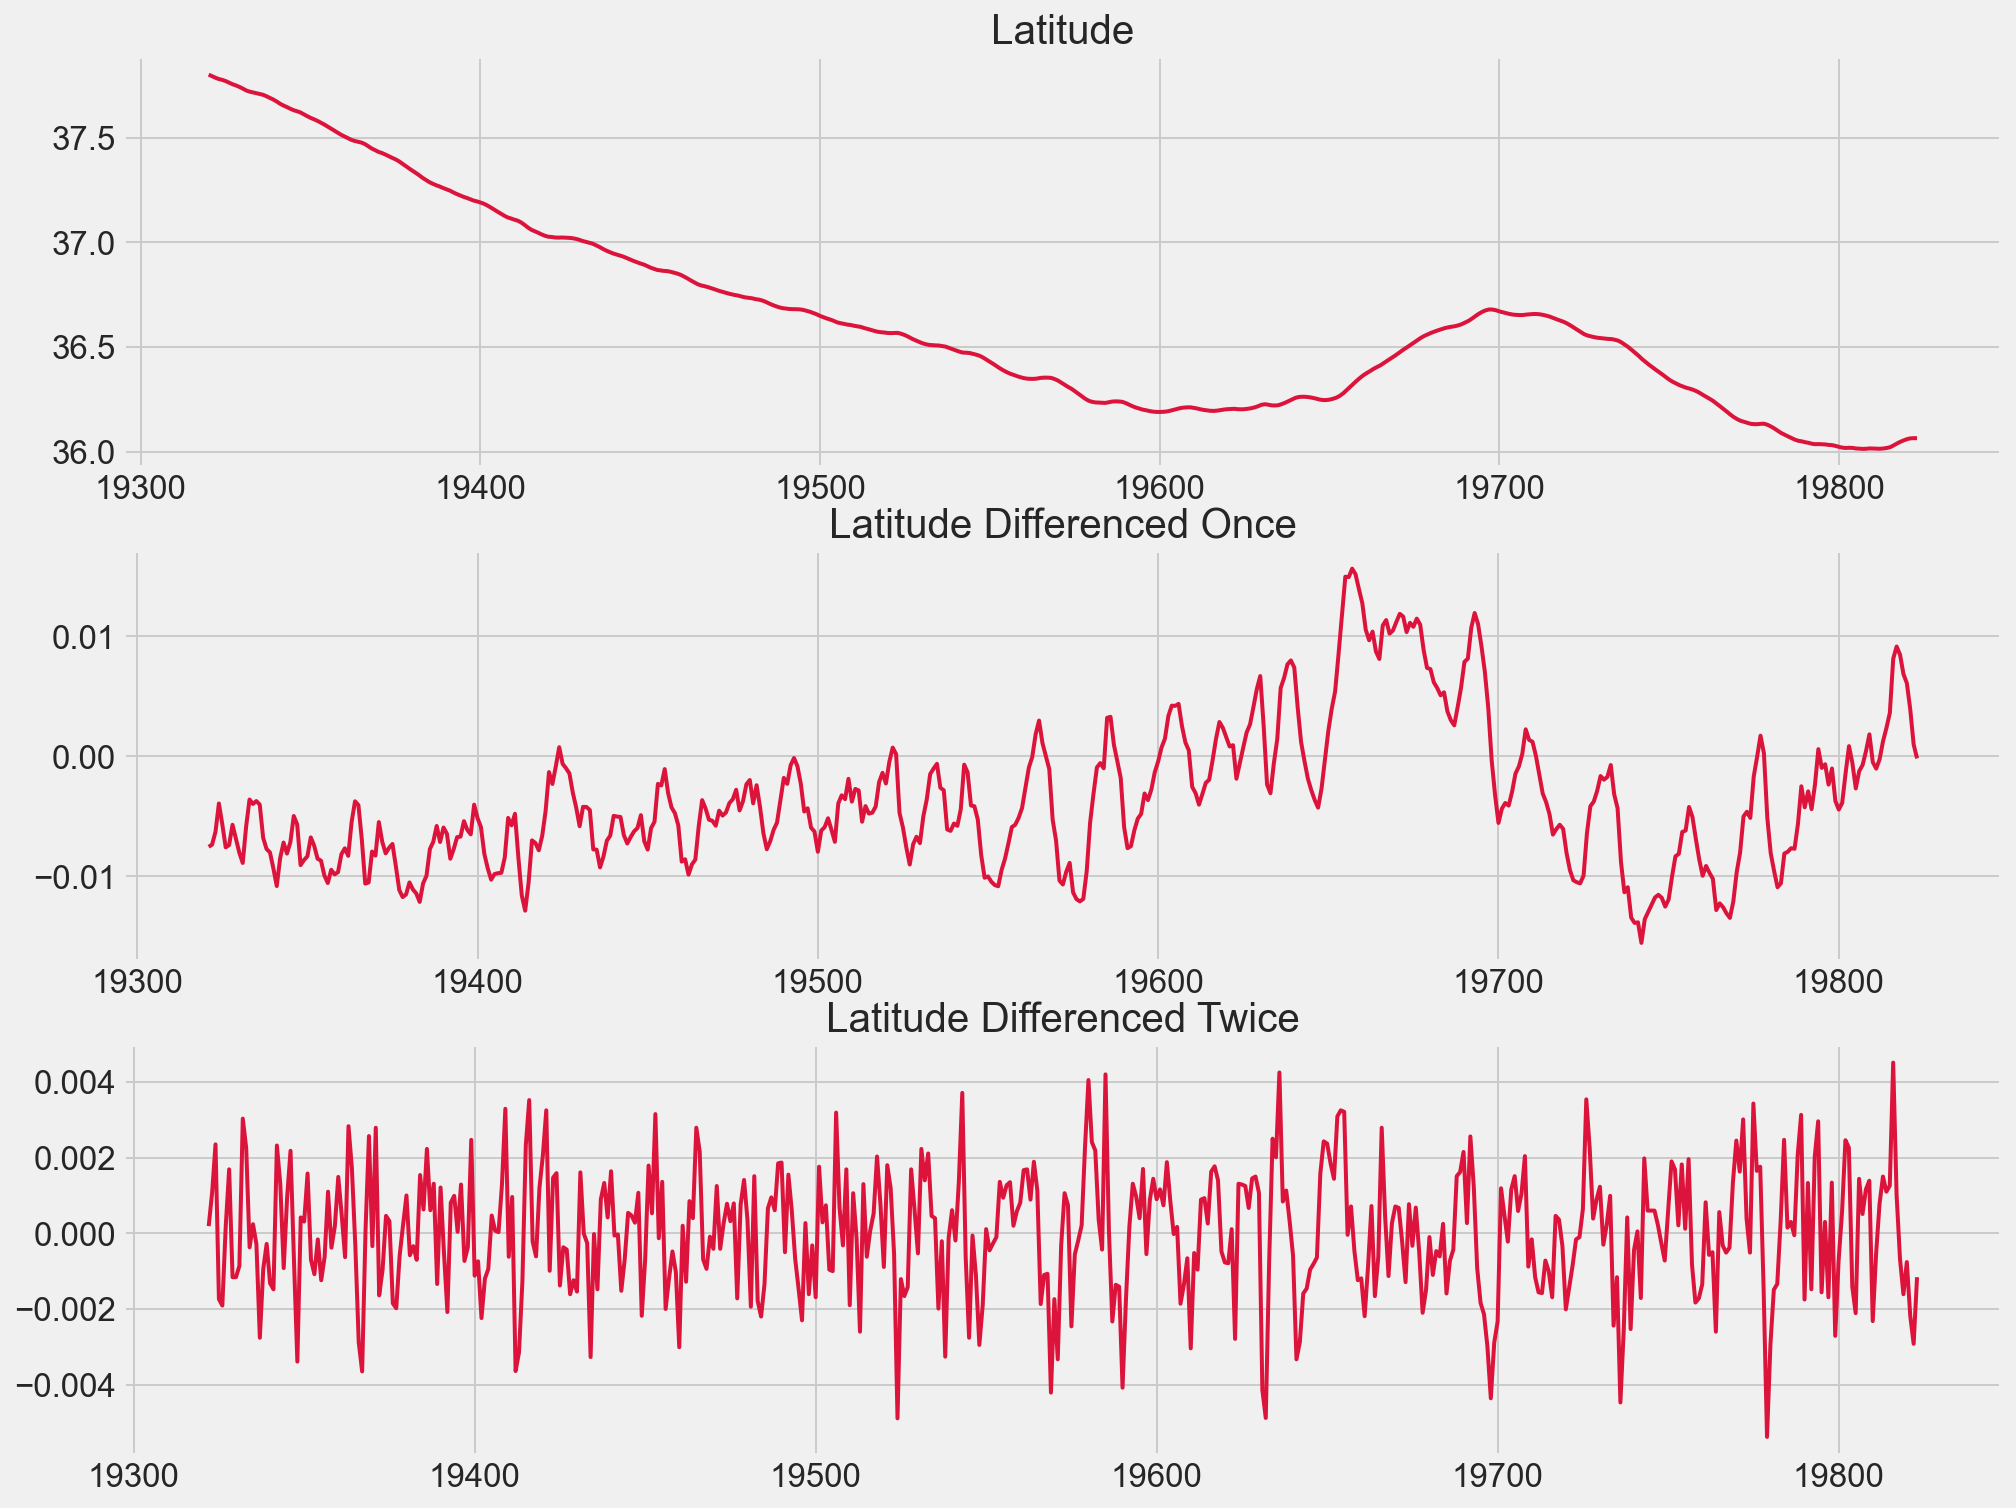

In [7]:
plot_diff(buoy_data, 35, 48, 'Latitude')

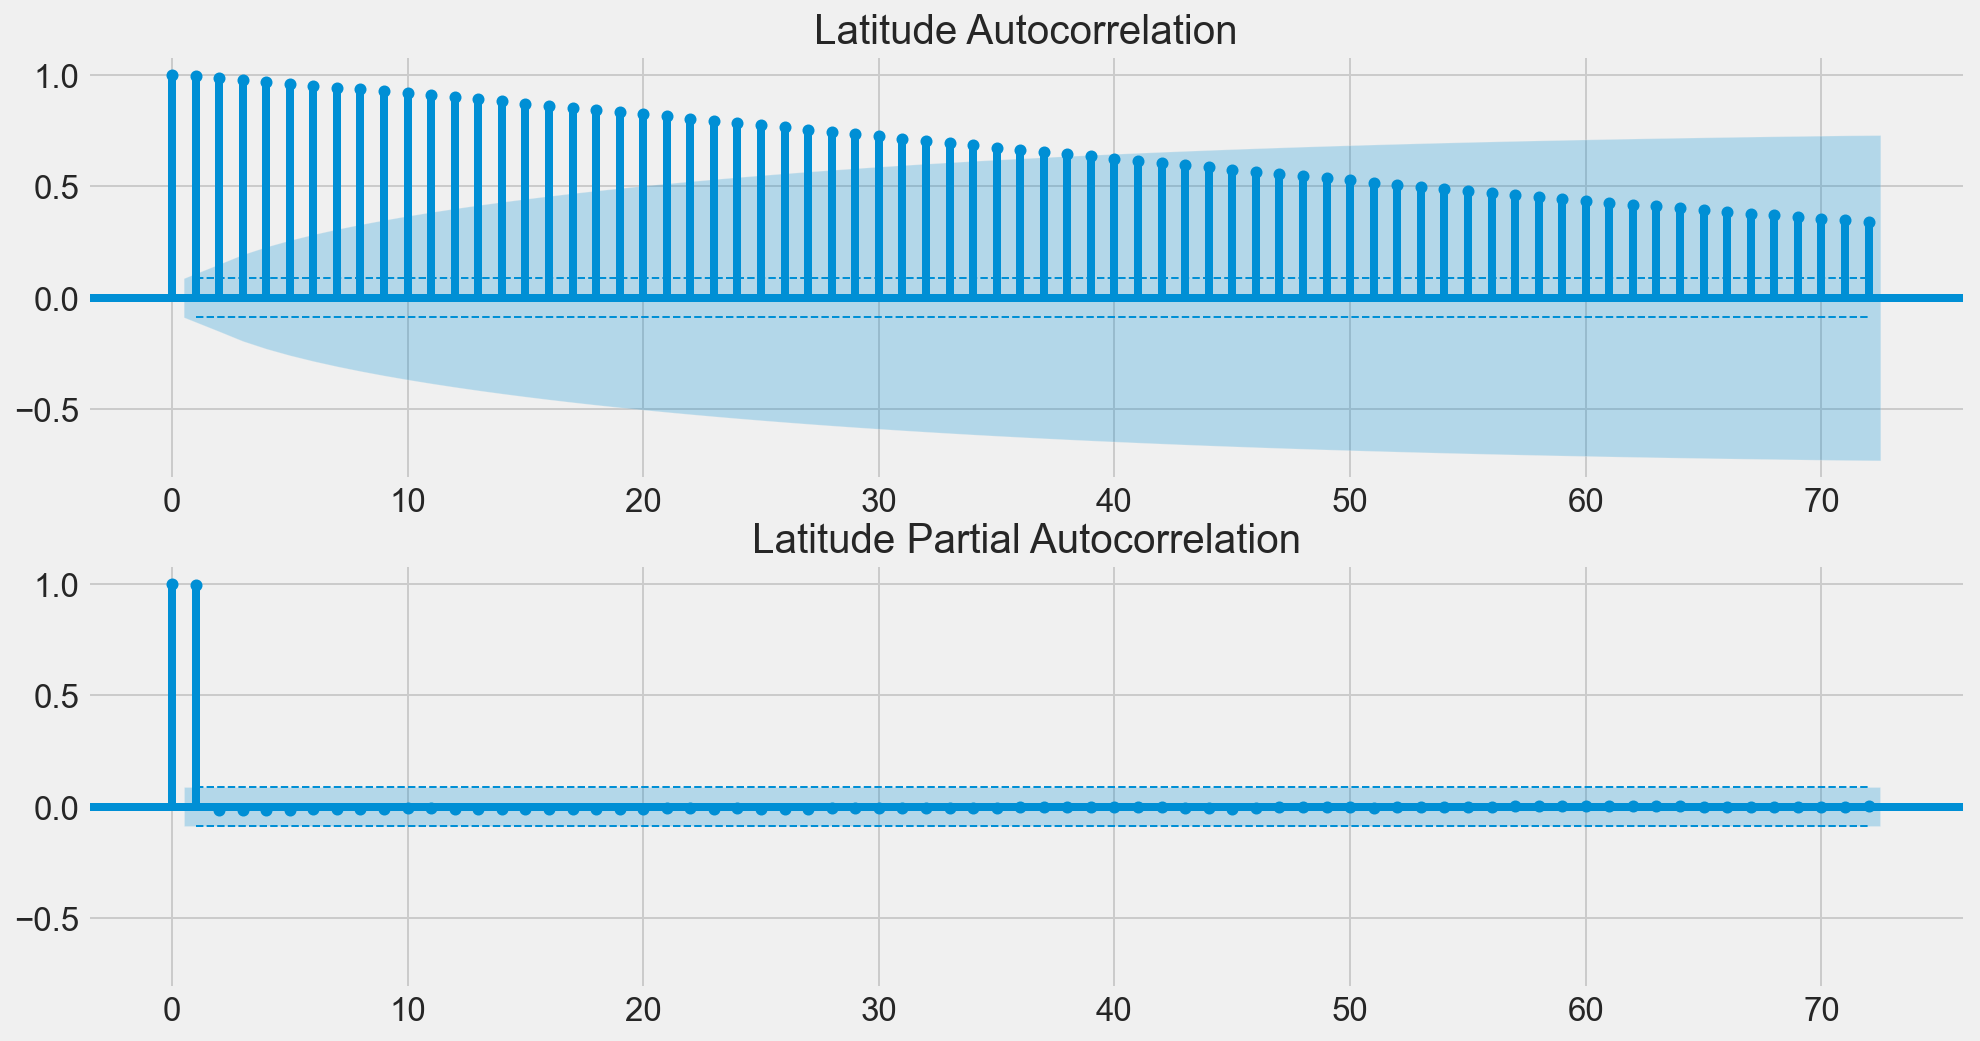

In [8]:
plot_autocorrs(buoy_data, 35, 'Latitude', 48, 72)

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  504
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2579.512
Date:                Thu, 25 Nov 2021   AIC                          -5079.024
Time:                        14:16:03   BIC                          -4910.280
Sample:                             0   HQIC                         -5012.821
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.085e-05   8.19e-05      0.377      0.706      -0.000       0.000
ar.L1          0.1322      0.811      0.163      0.870      -1.458       1.722
ar.L2          0.0467      0.211      0.222      0.8

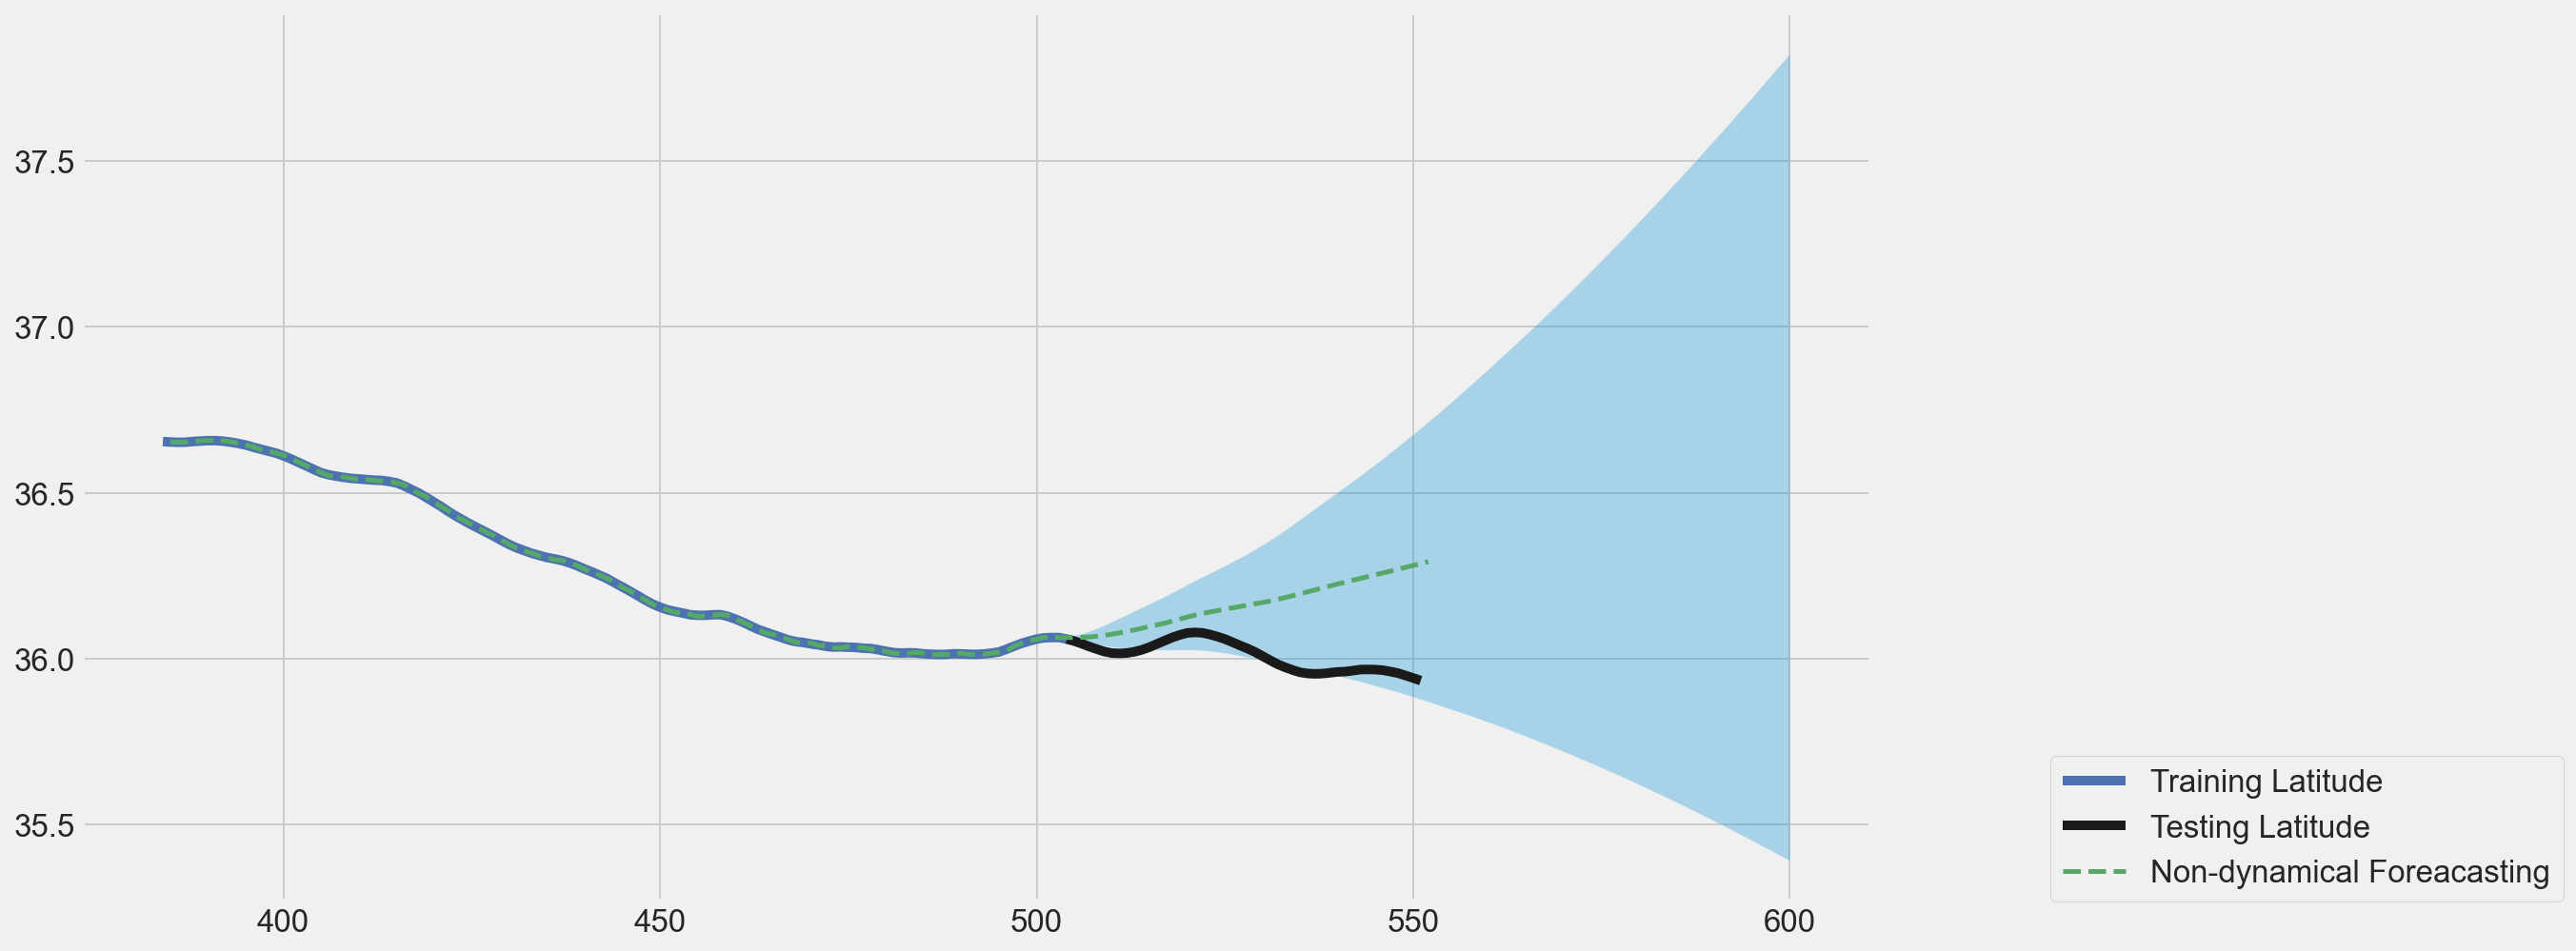

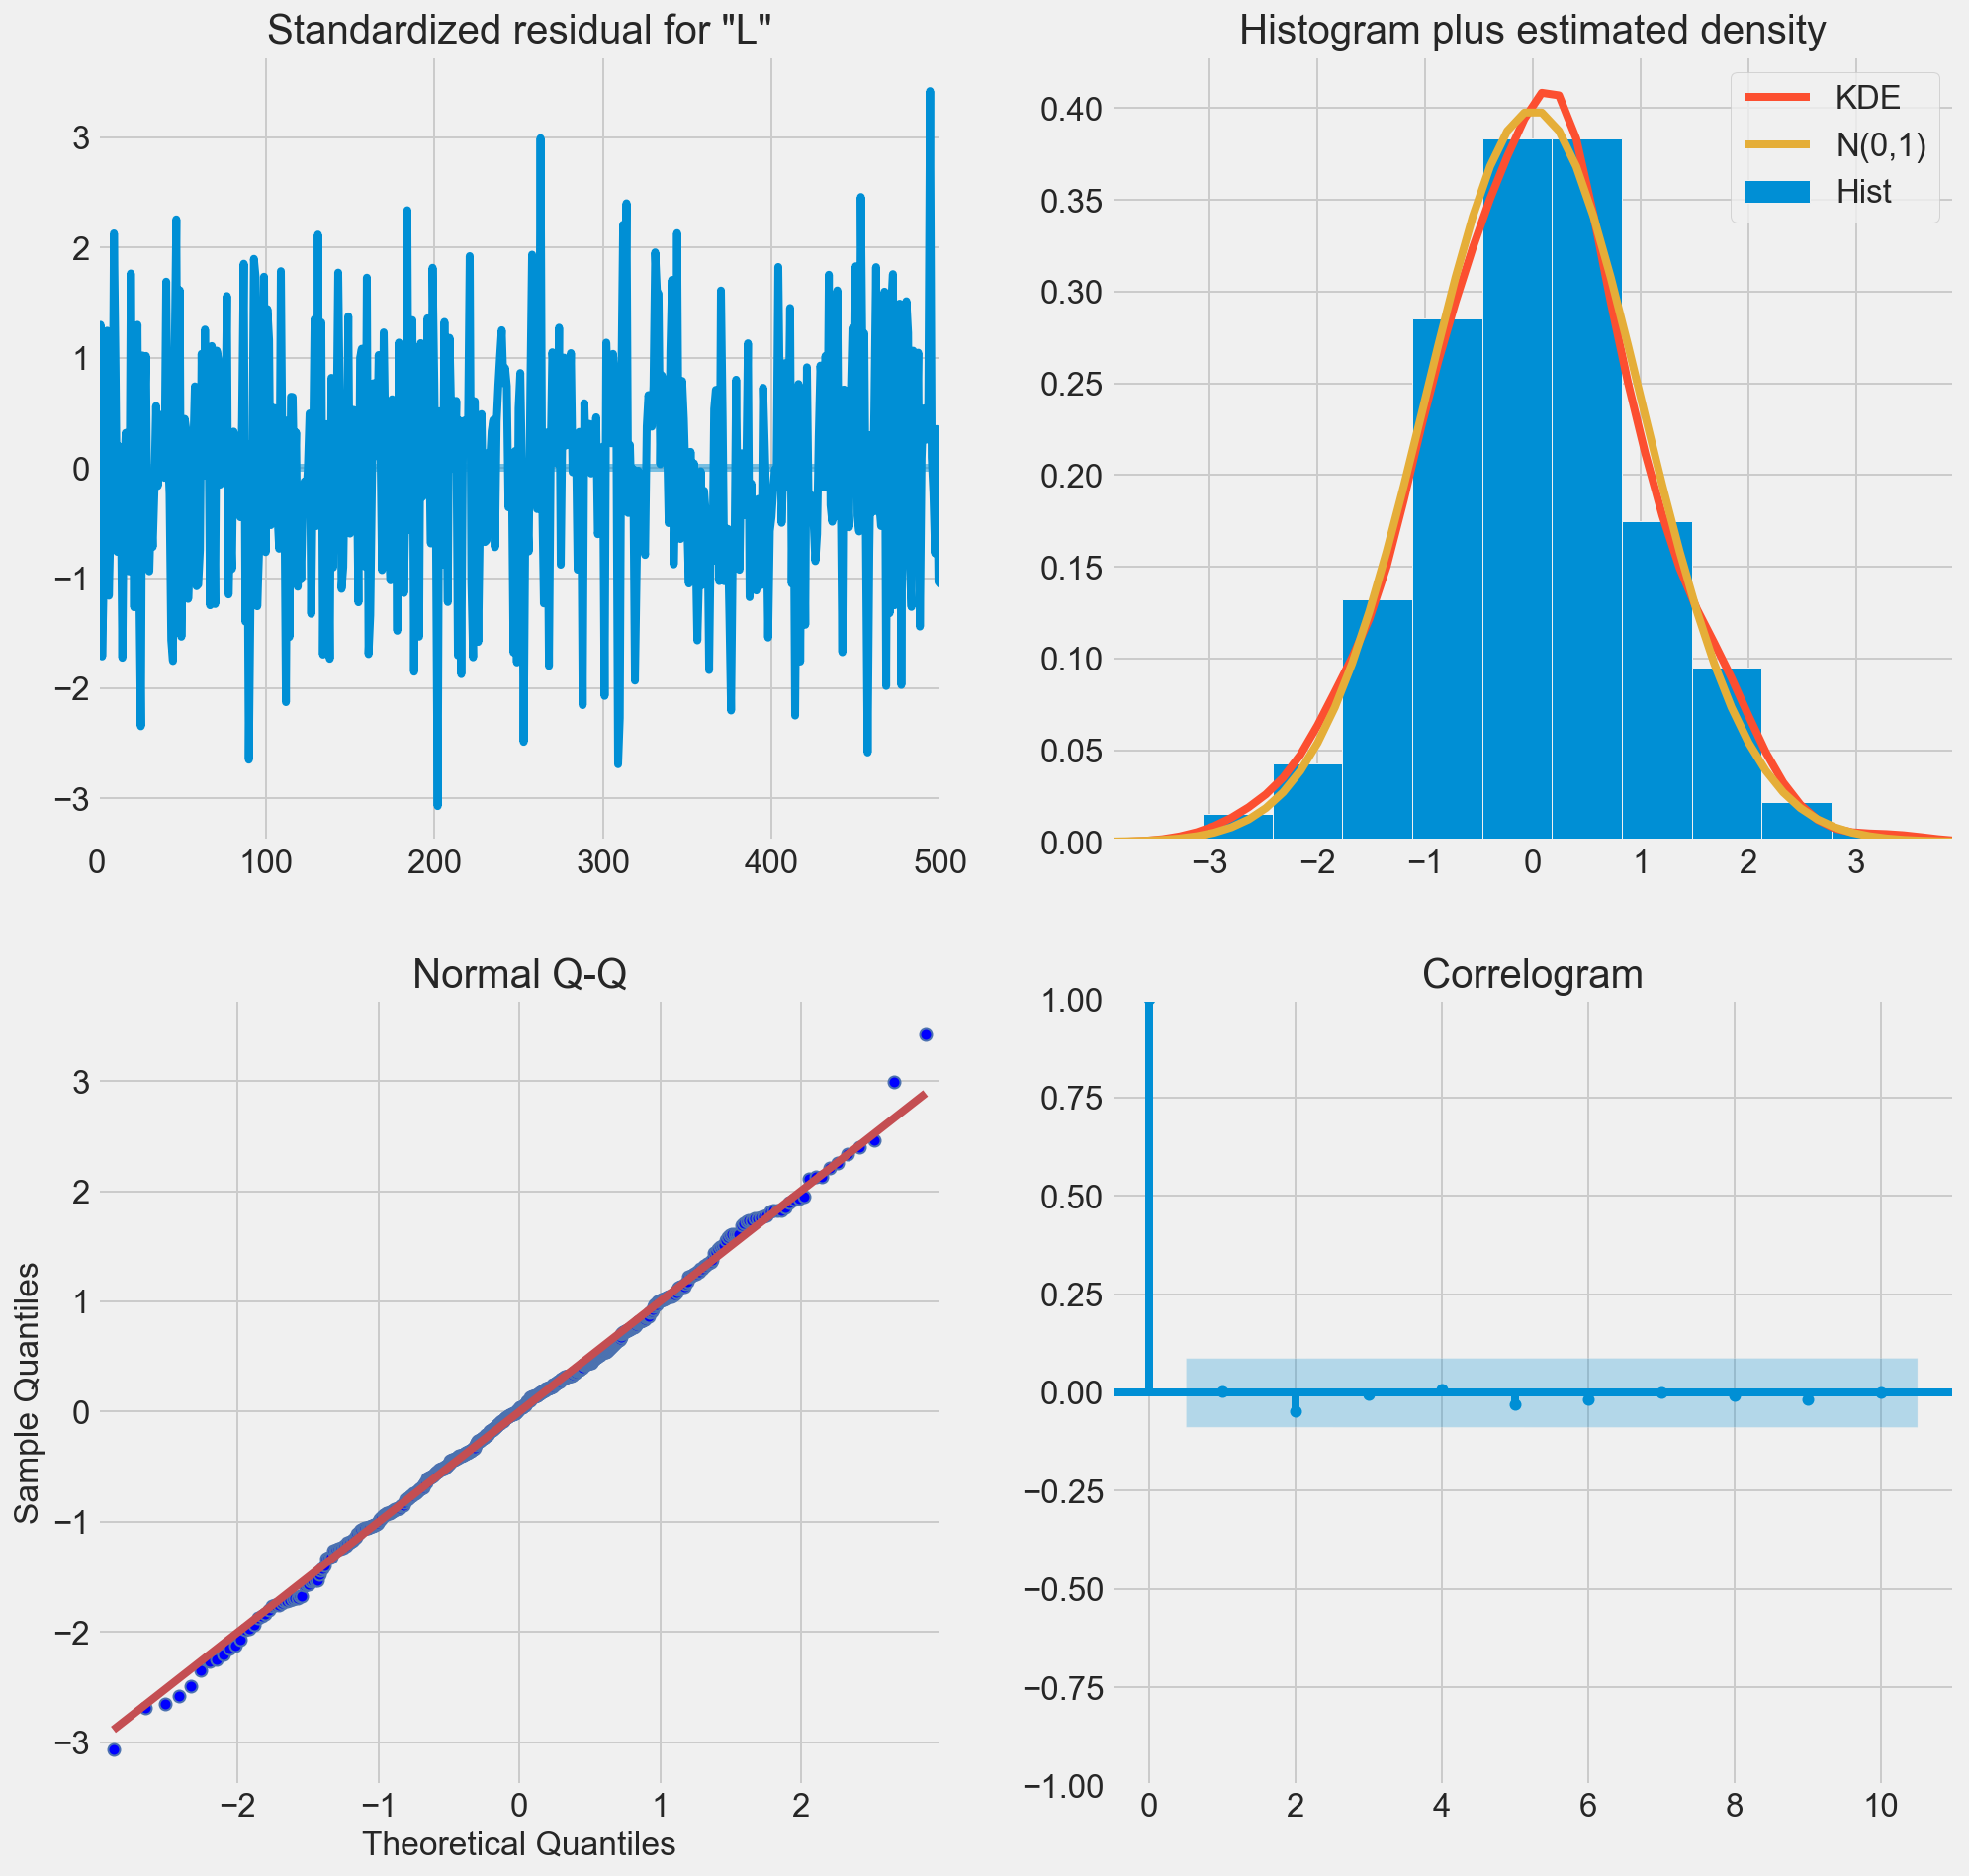

In [9]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1),
                     start_p=24, end_p=48, exog_features=[])

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  504
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2579.741
Date:                Thu, 25 Nov 2021   AIC                          -5077.483
Time:                        14:16:18   BIC                          -4904.520
Sample:                             0   HQIC                         -5009.624
                                - 504                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       3.958e-05   8.43e-05      0.469      0.639      -0.000       0.000
Peak Direction -3.146e-07    3.8e-07     -0.829      0.407   -1.06e-06    4.29e-07
ar.L1              0.1327      0.779

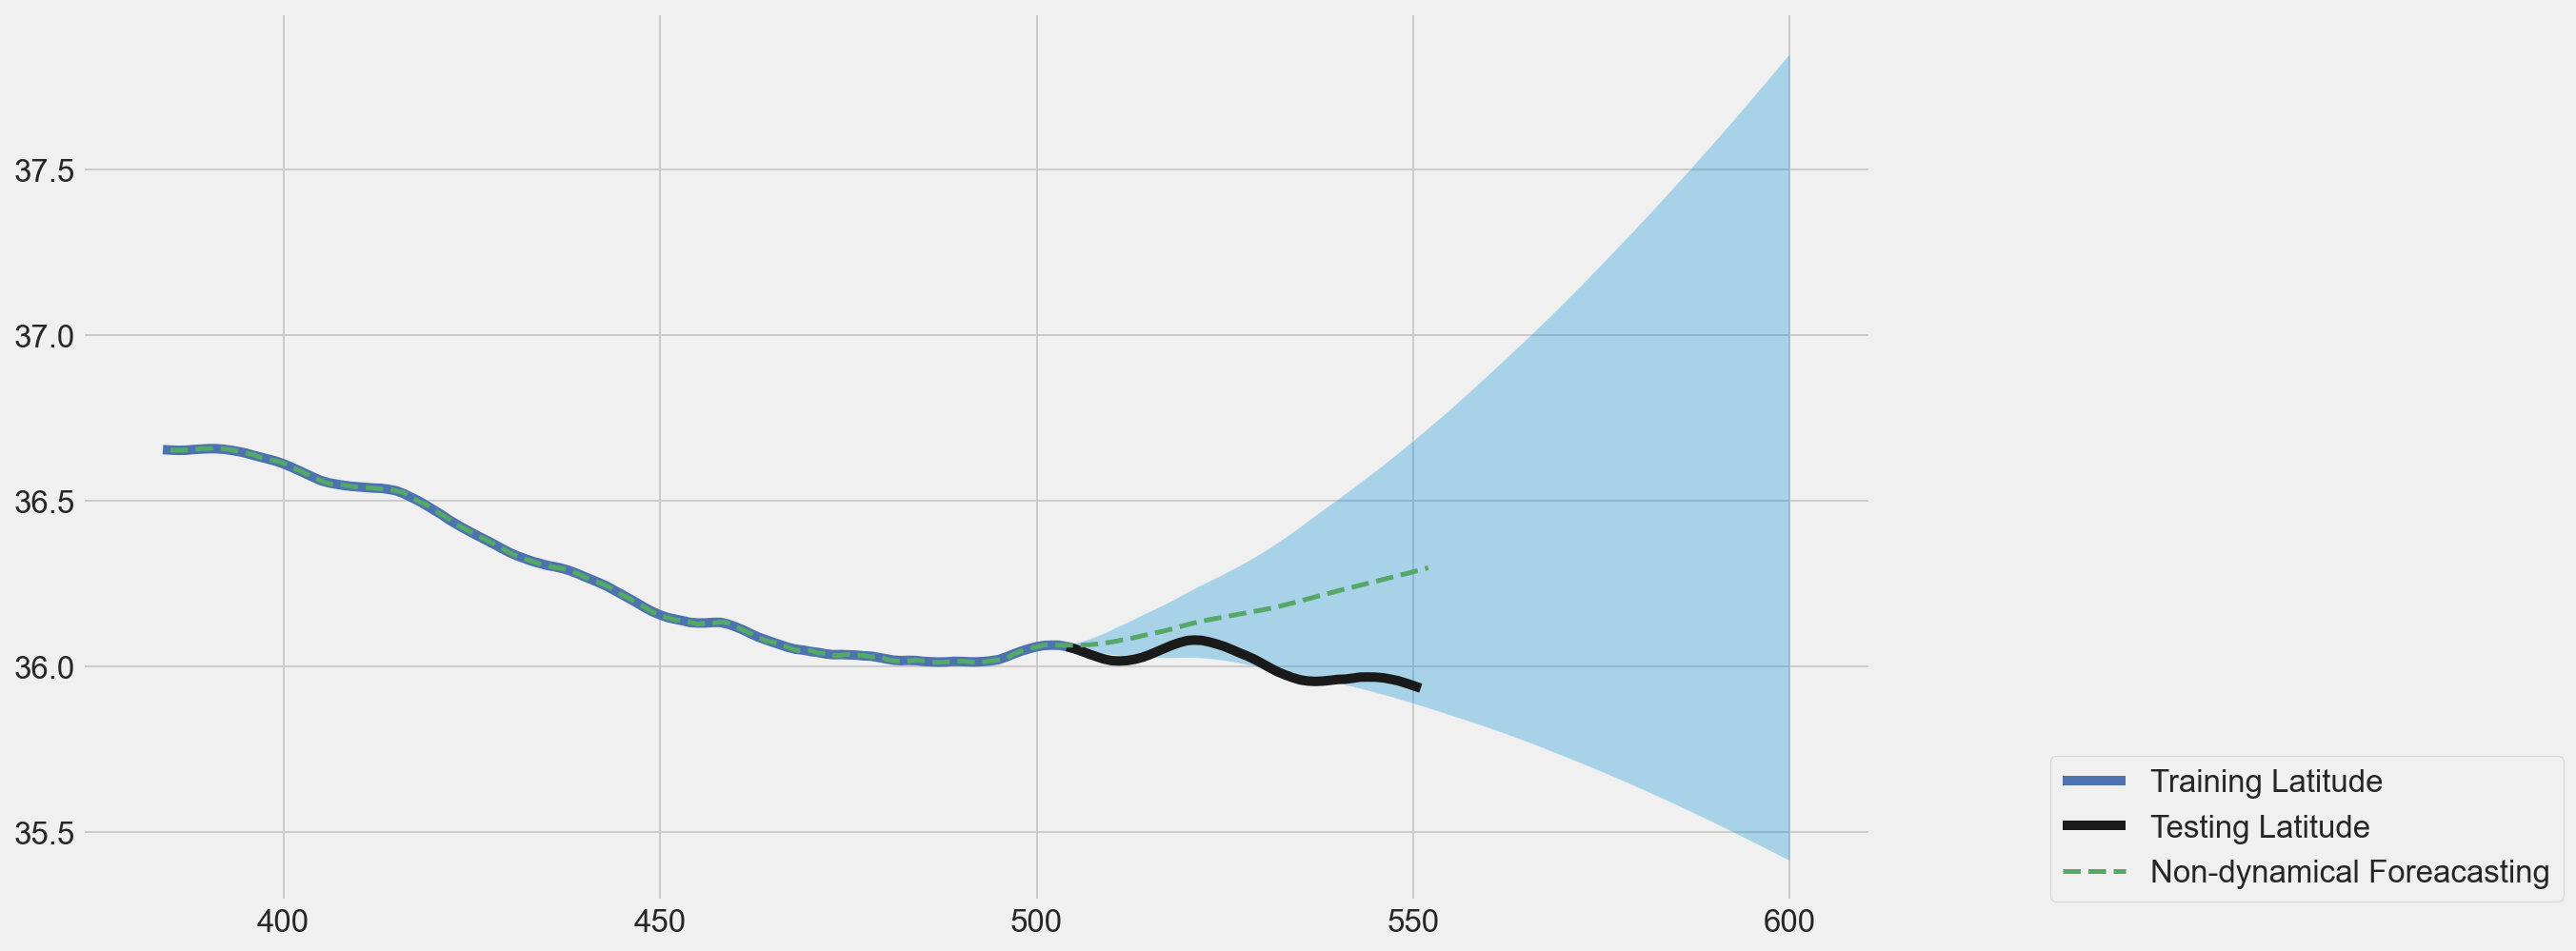

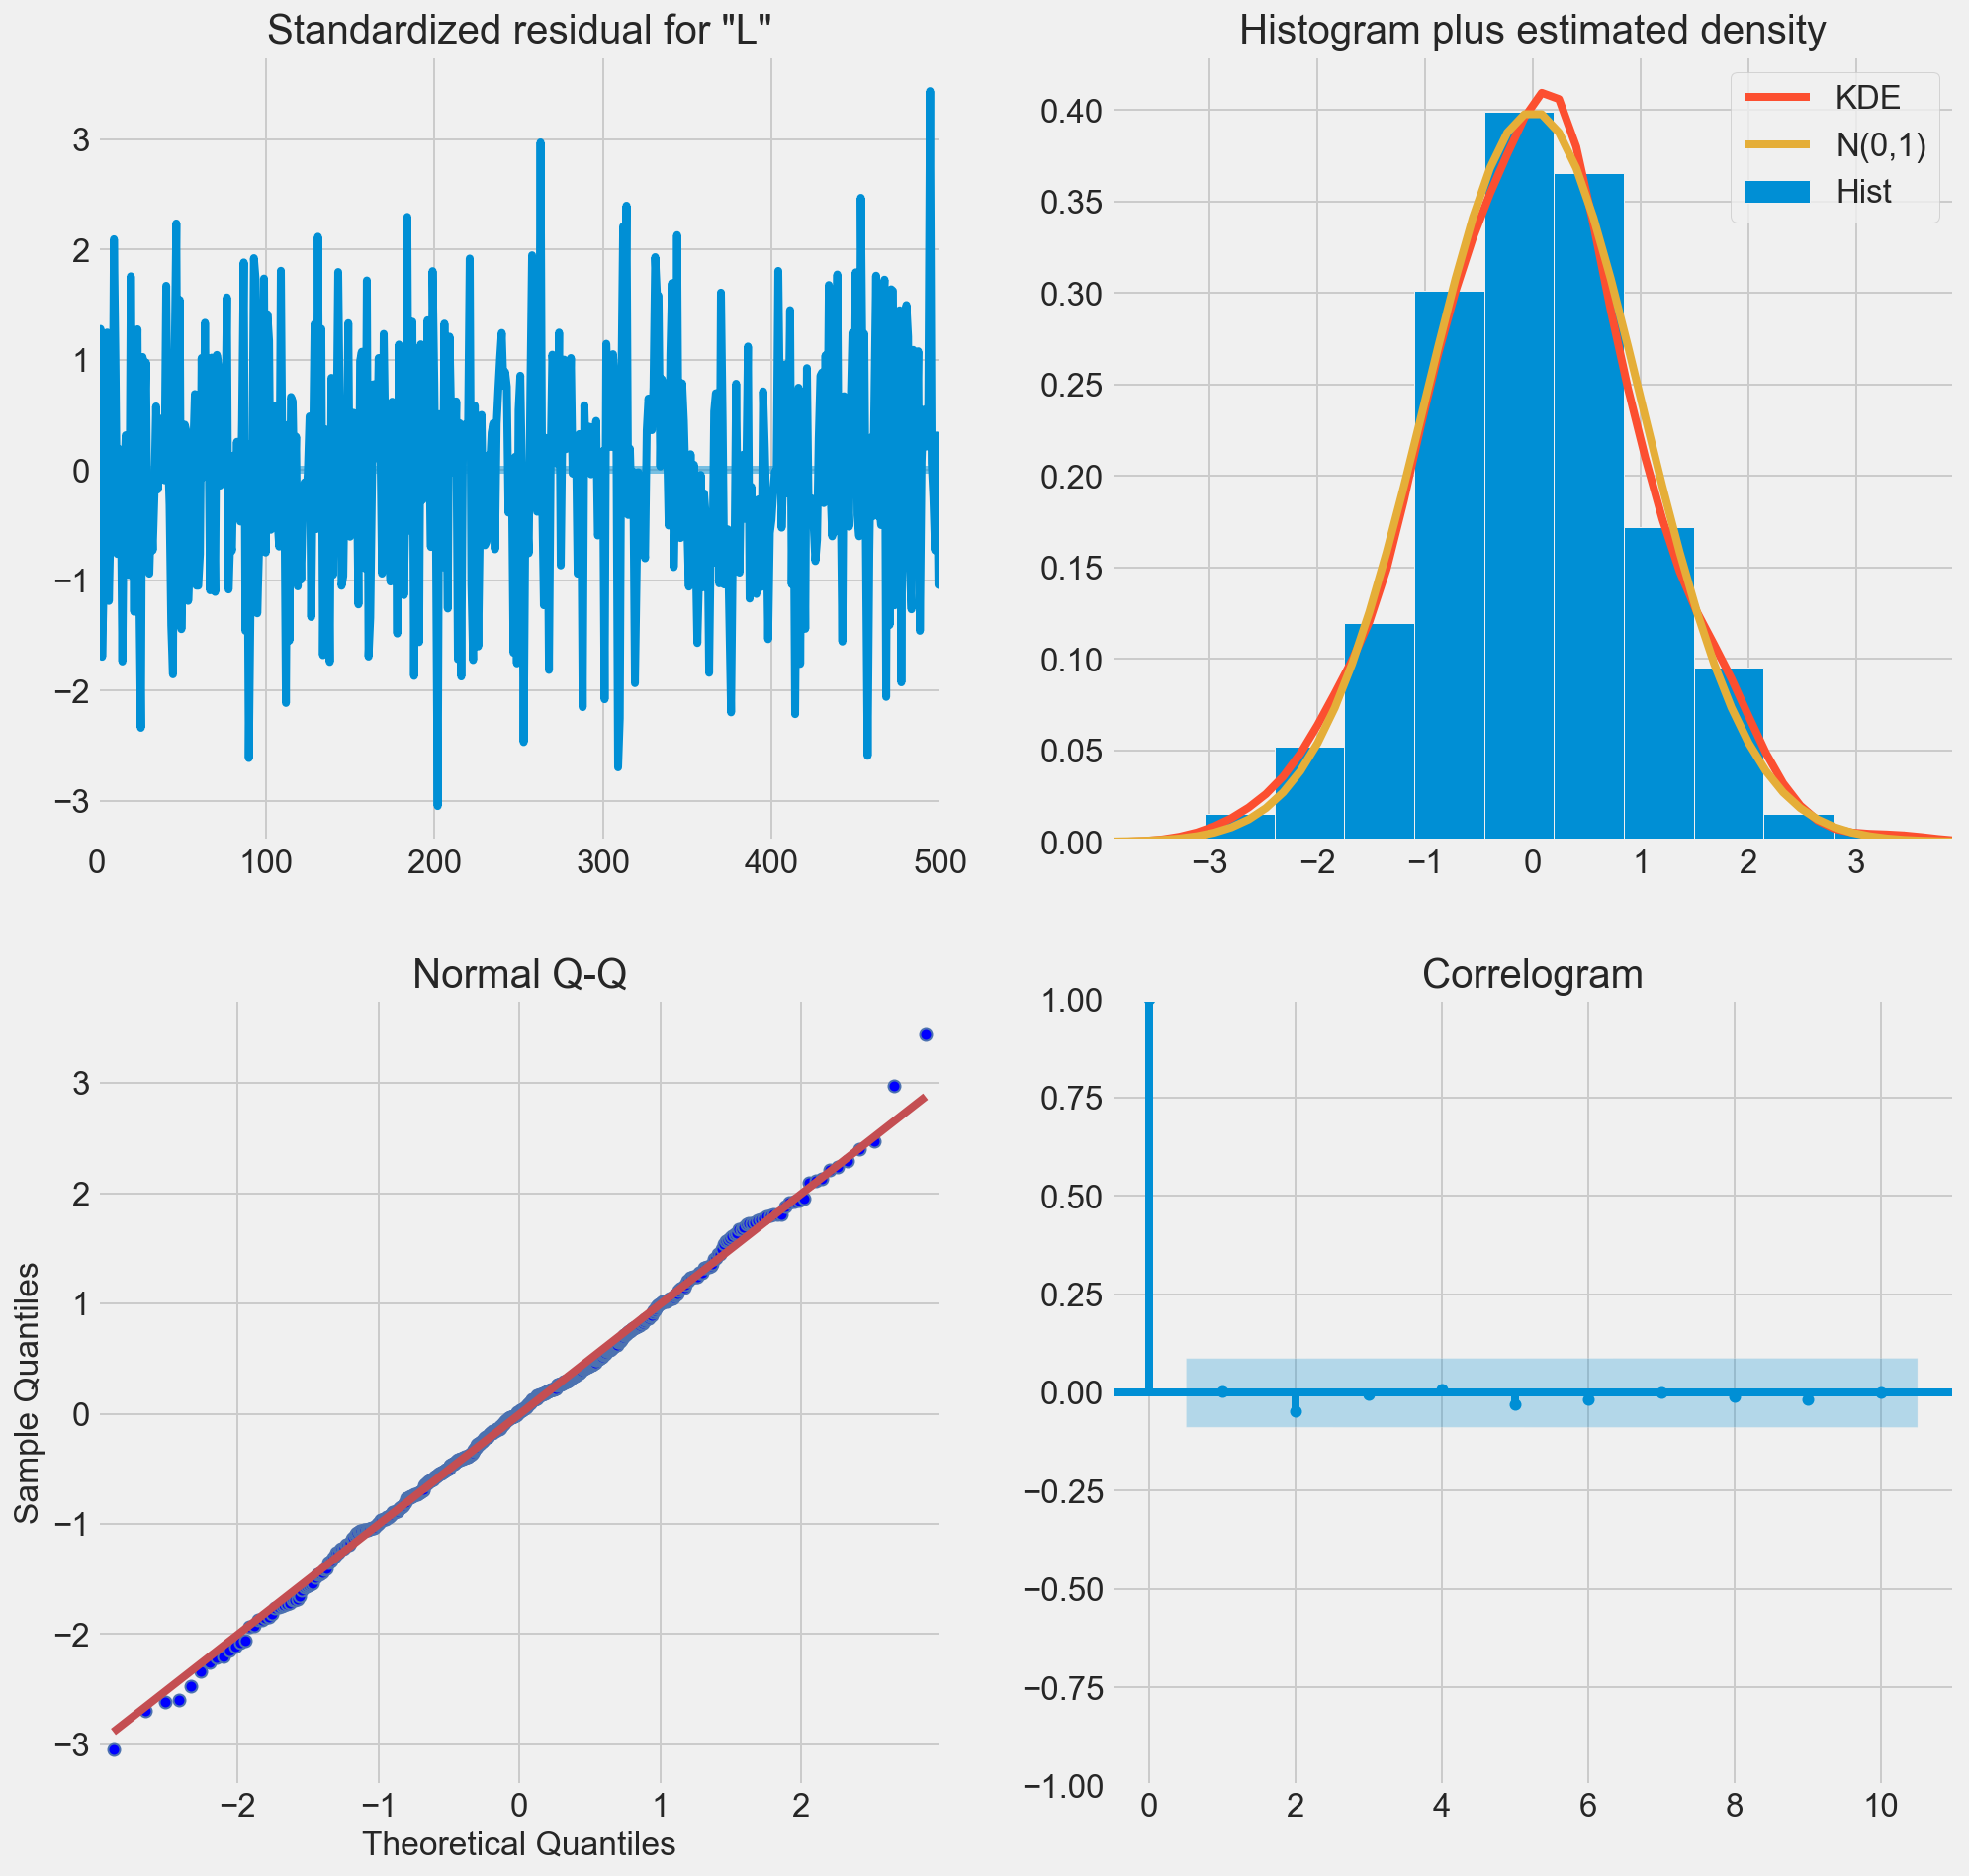

In [10]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1),
                     start_p=24, end_p=48, exog_features=['Peak Direction'])

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  504
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2579.843
Date:                Thu, 25 Nov 2021   AIC                          -5075.686
Time:                        14:16:31   BIC                          -4898.505
Sample:                             0   HQIC                         -5006.172
                                - 504                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                3.966e-05   8.46e-05      0.469      0.639      -0.000       0.000
Significant Wave Height     0.0004      0.000      1.219      0.223      -0.000       0.001


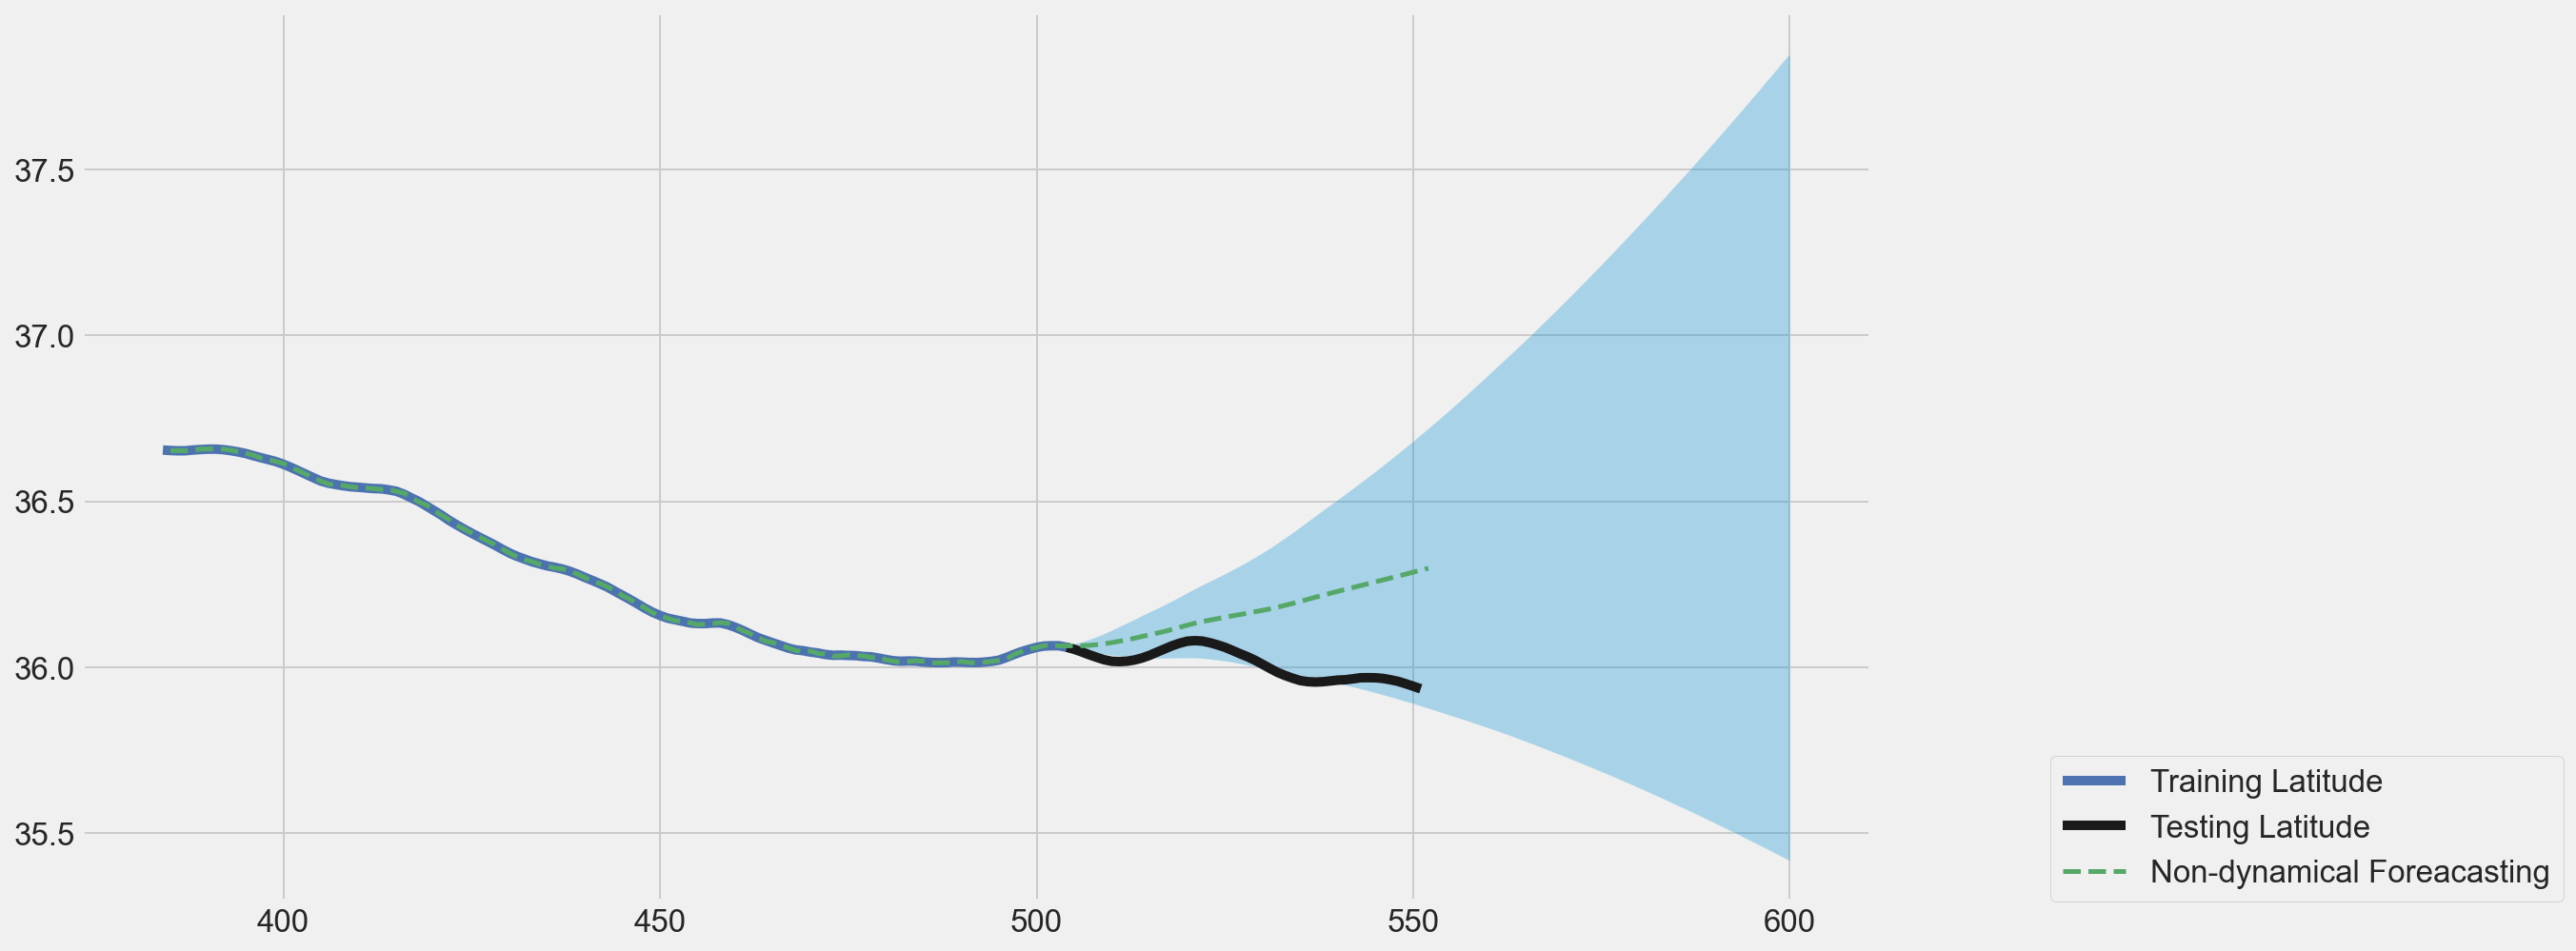

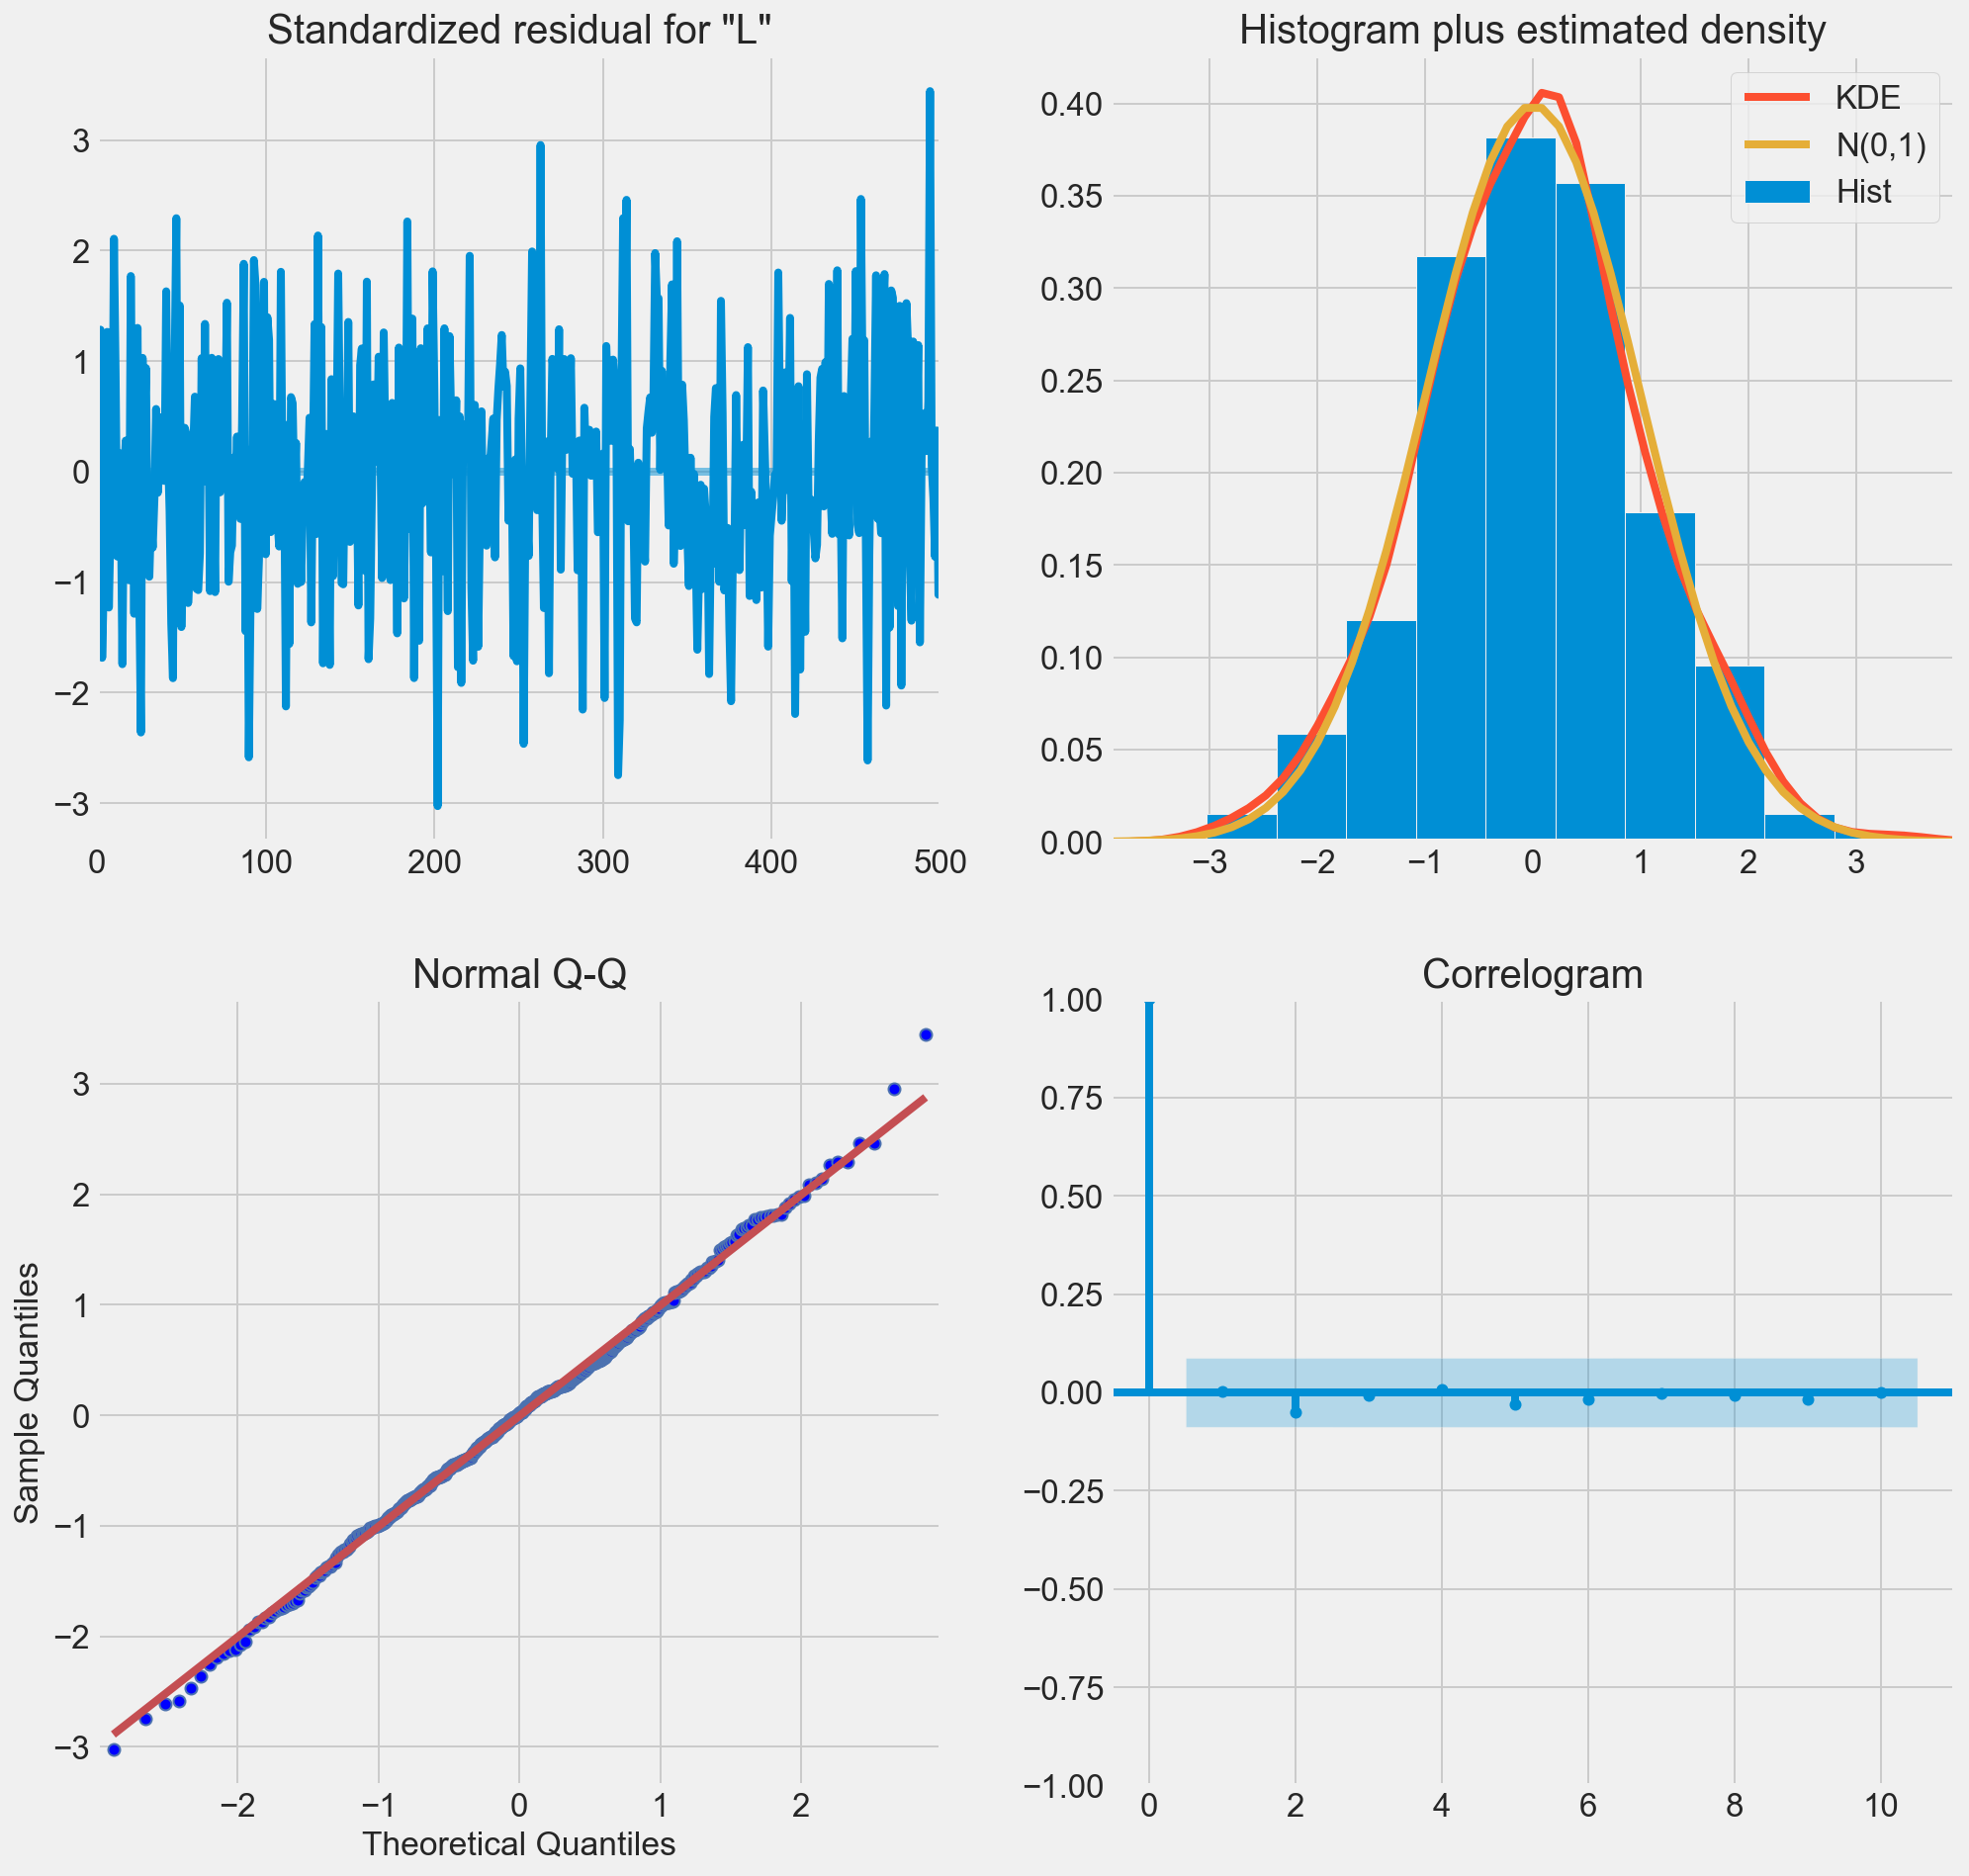

In [11]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1),
                     start_p=24, end_p=48, exog_features=['Significant Wave Height', 'Peak Direction'])

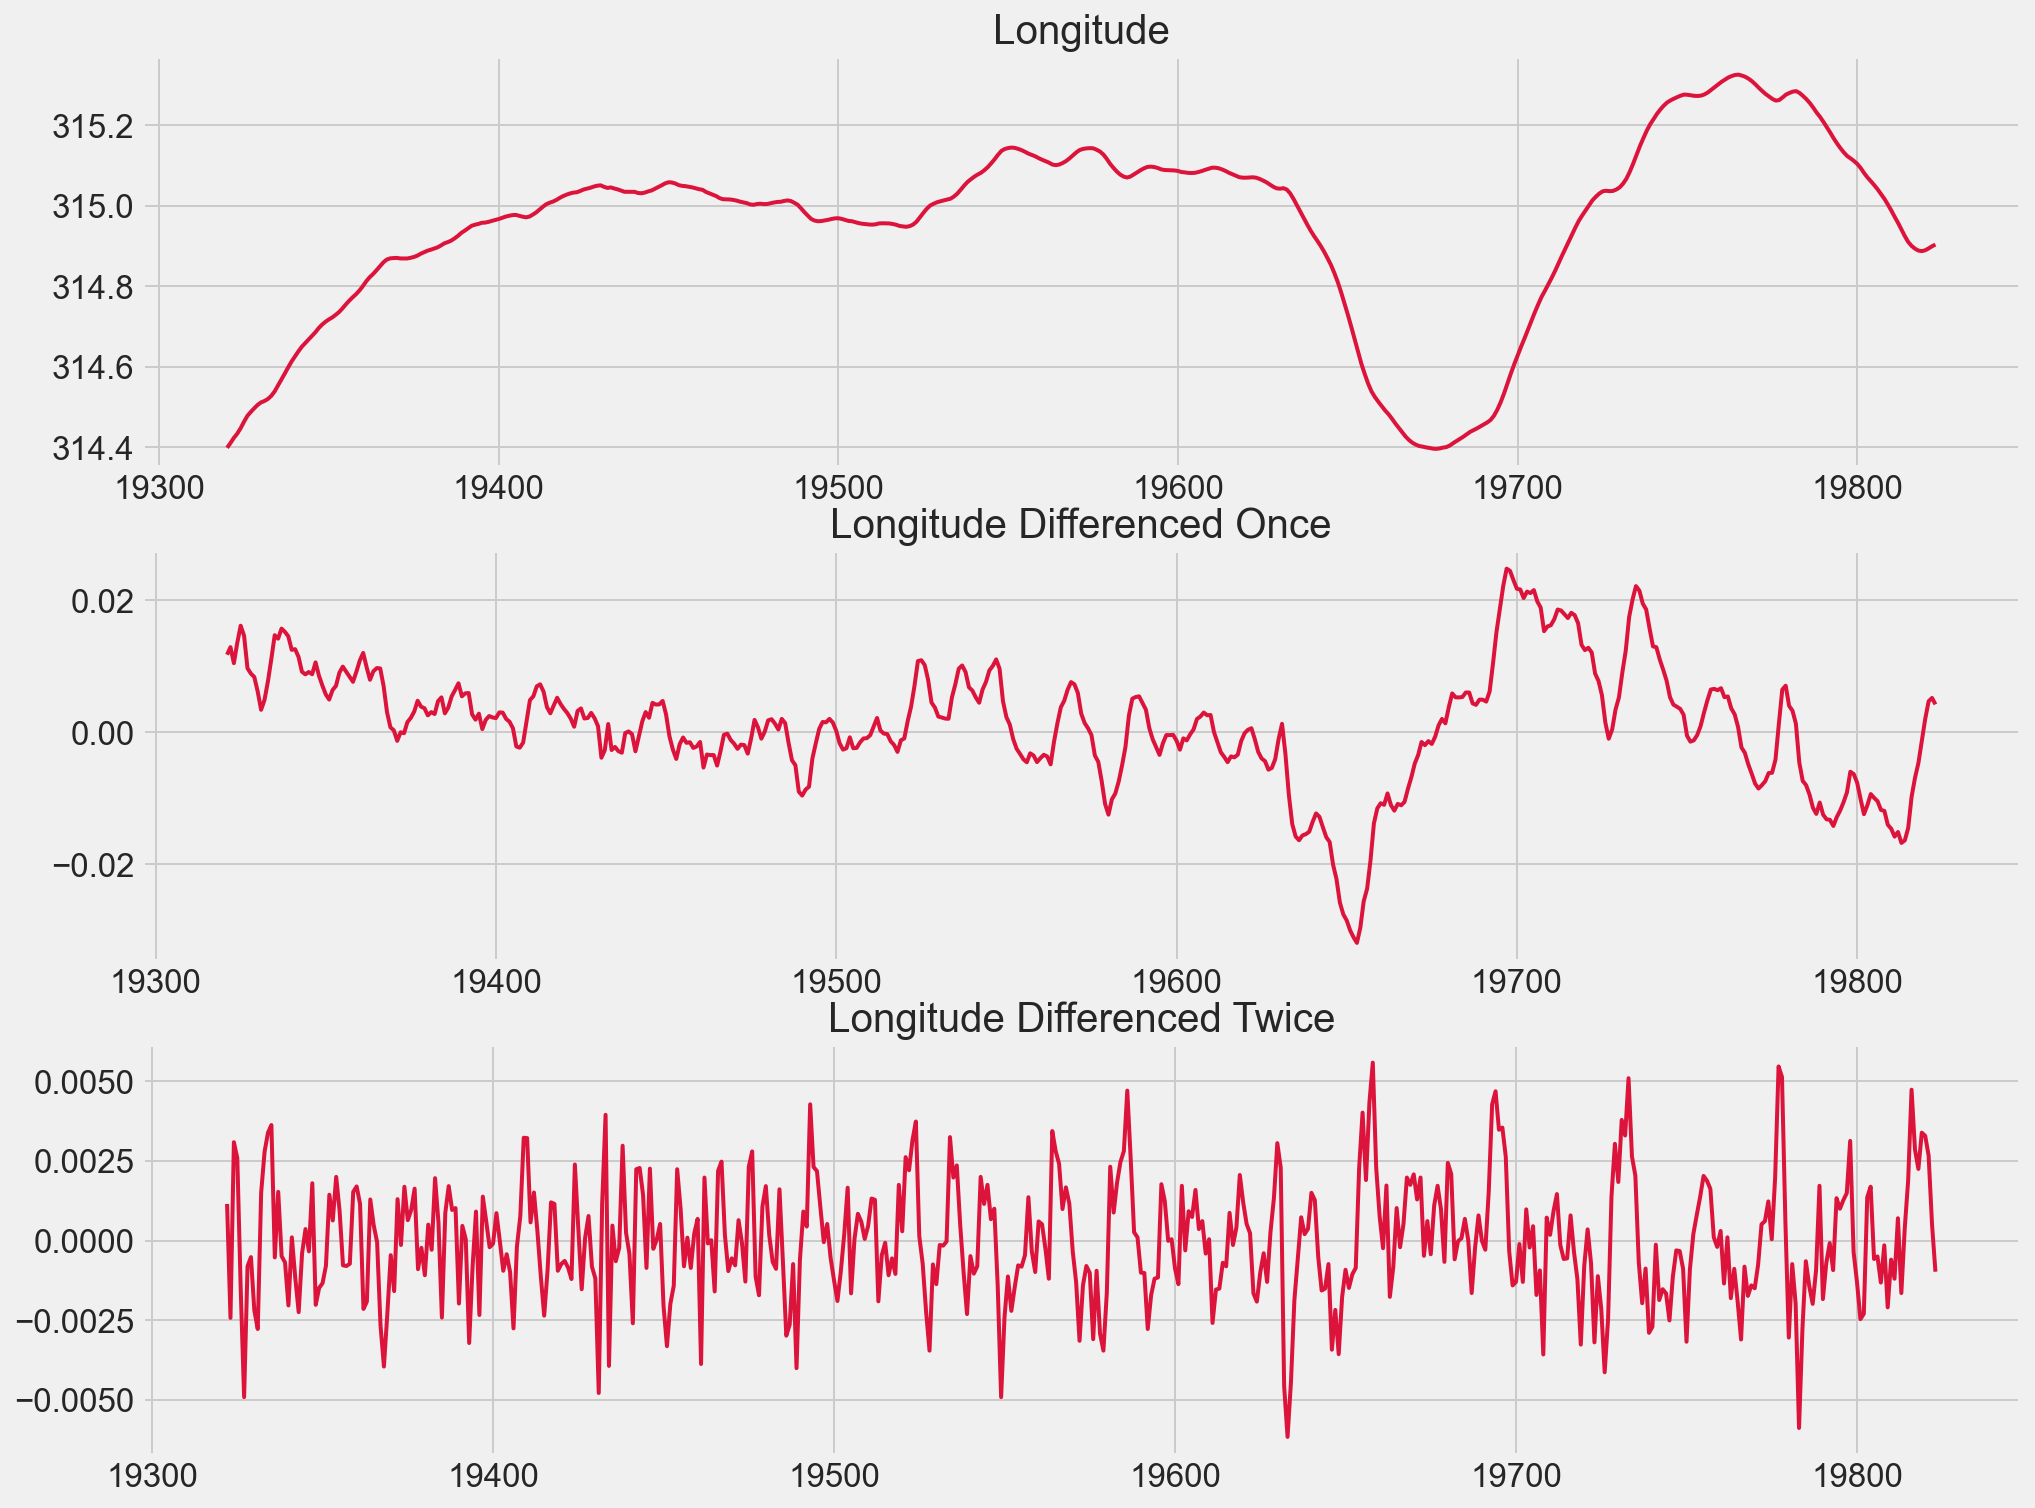

In [12]:
plot_diff(buoy_data, 35, 48, 'Longitude')

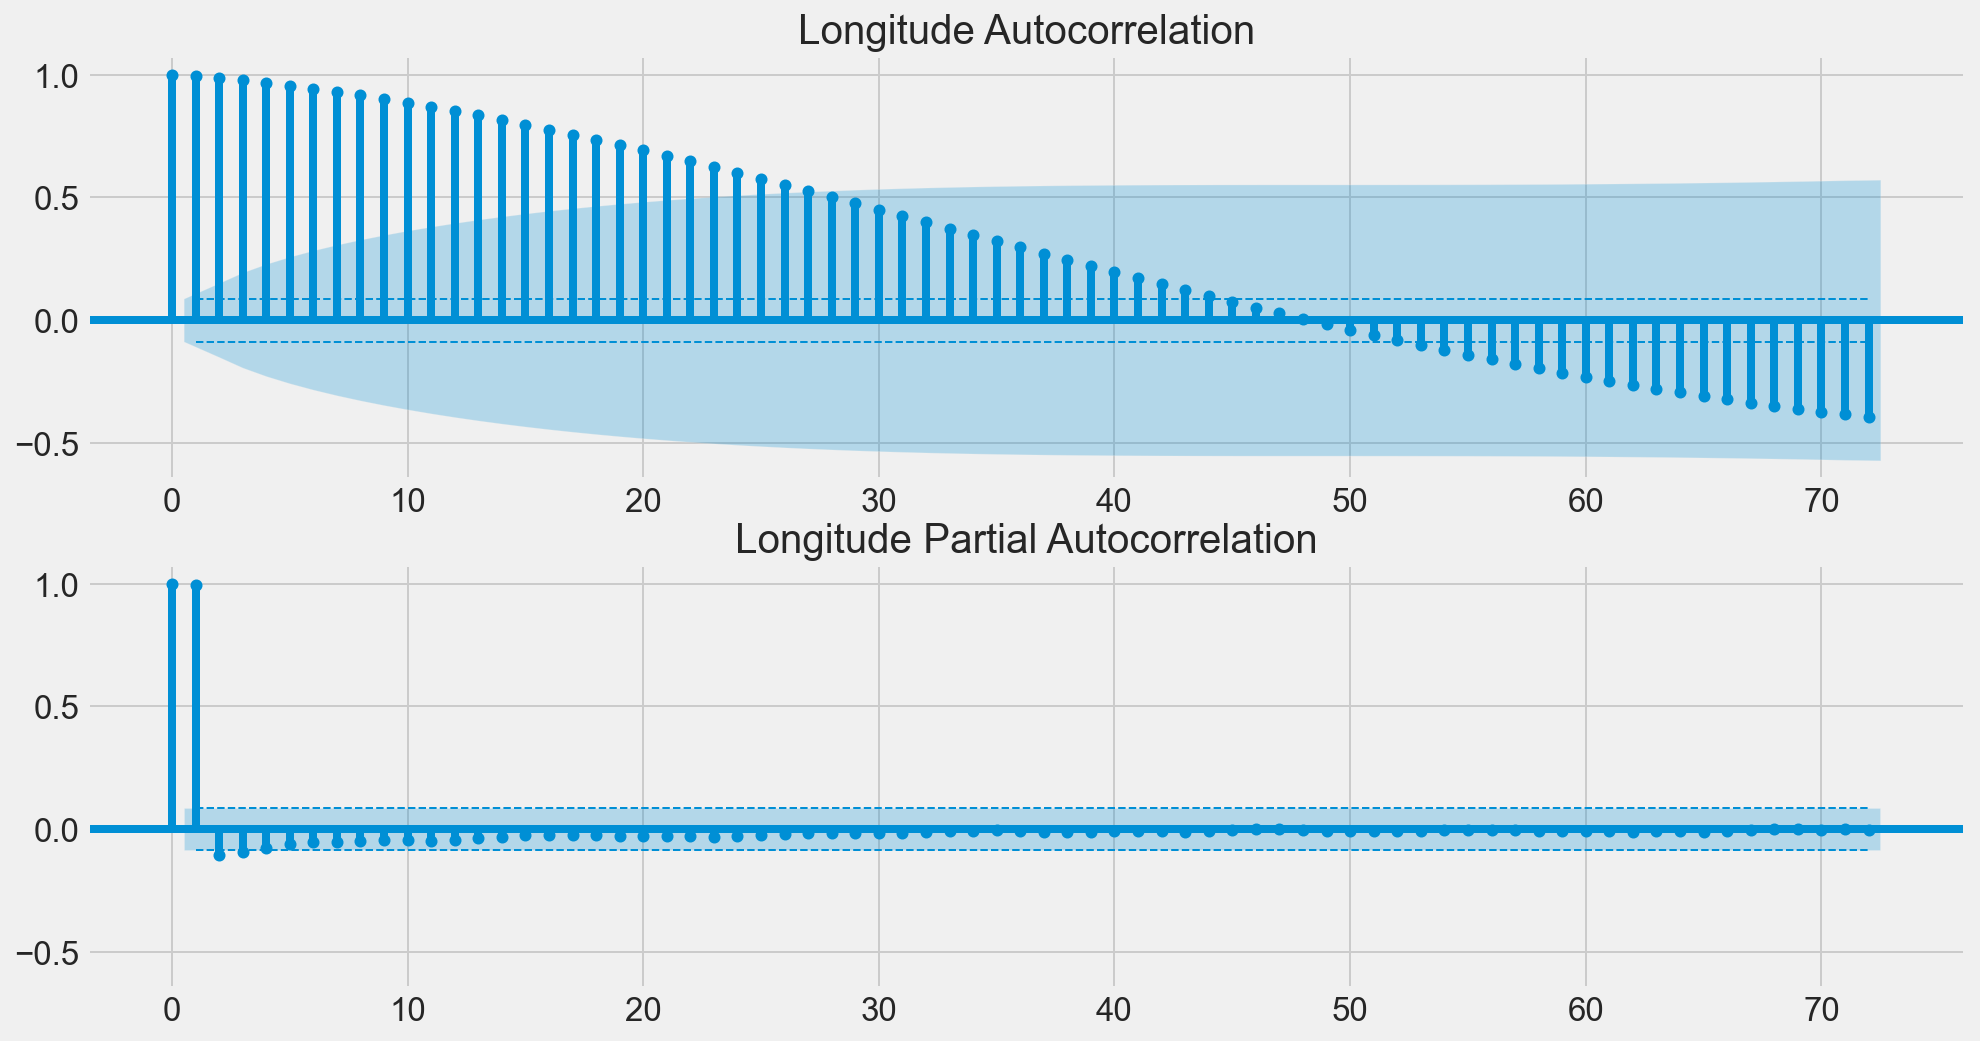

In [13]:
plot_autocorrs(buoy_data, 35, 'Longitude', 48, 72)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  504
Model:              SARIMAX(26, 2, 4)   Log Likelihood                2538.331
Date:                Thu, 25 Nov 2021   AIC                          -5012.662
Time:                        14:16:42   BIC                          -4877.667
Sample:                             0   HQIC                         -4959.699
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.84e-05   9.86e-05     -0.187      0.852      -0.000       0.000
ar.L1          0.2572      1.118      0.230      0.818      -1.933       2.448
ar.L2          0.0463      1.137      0.041      0.9

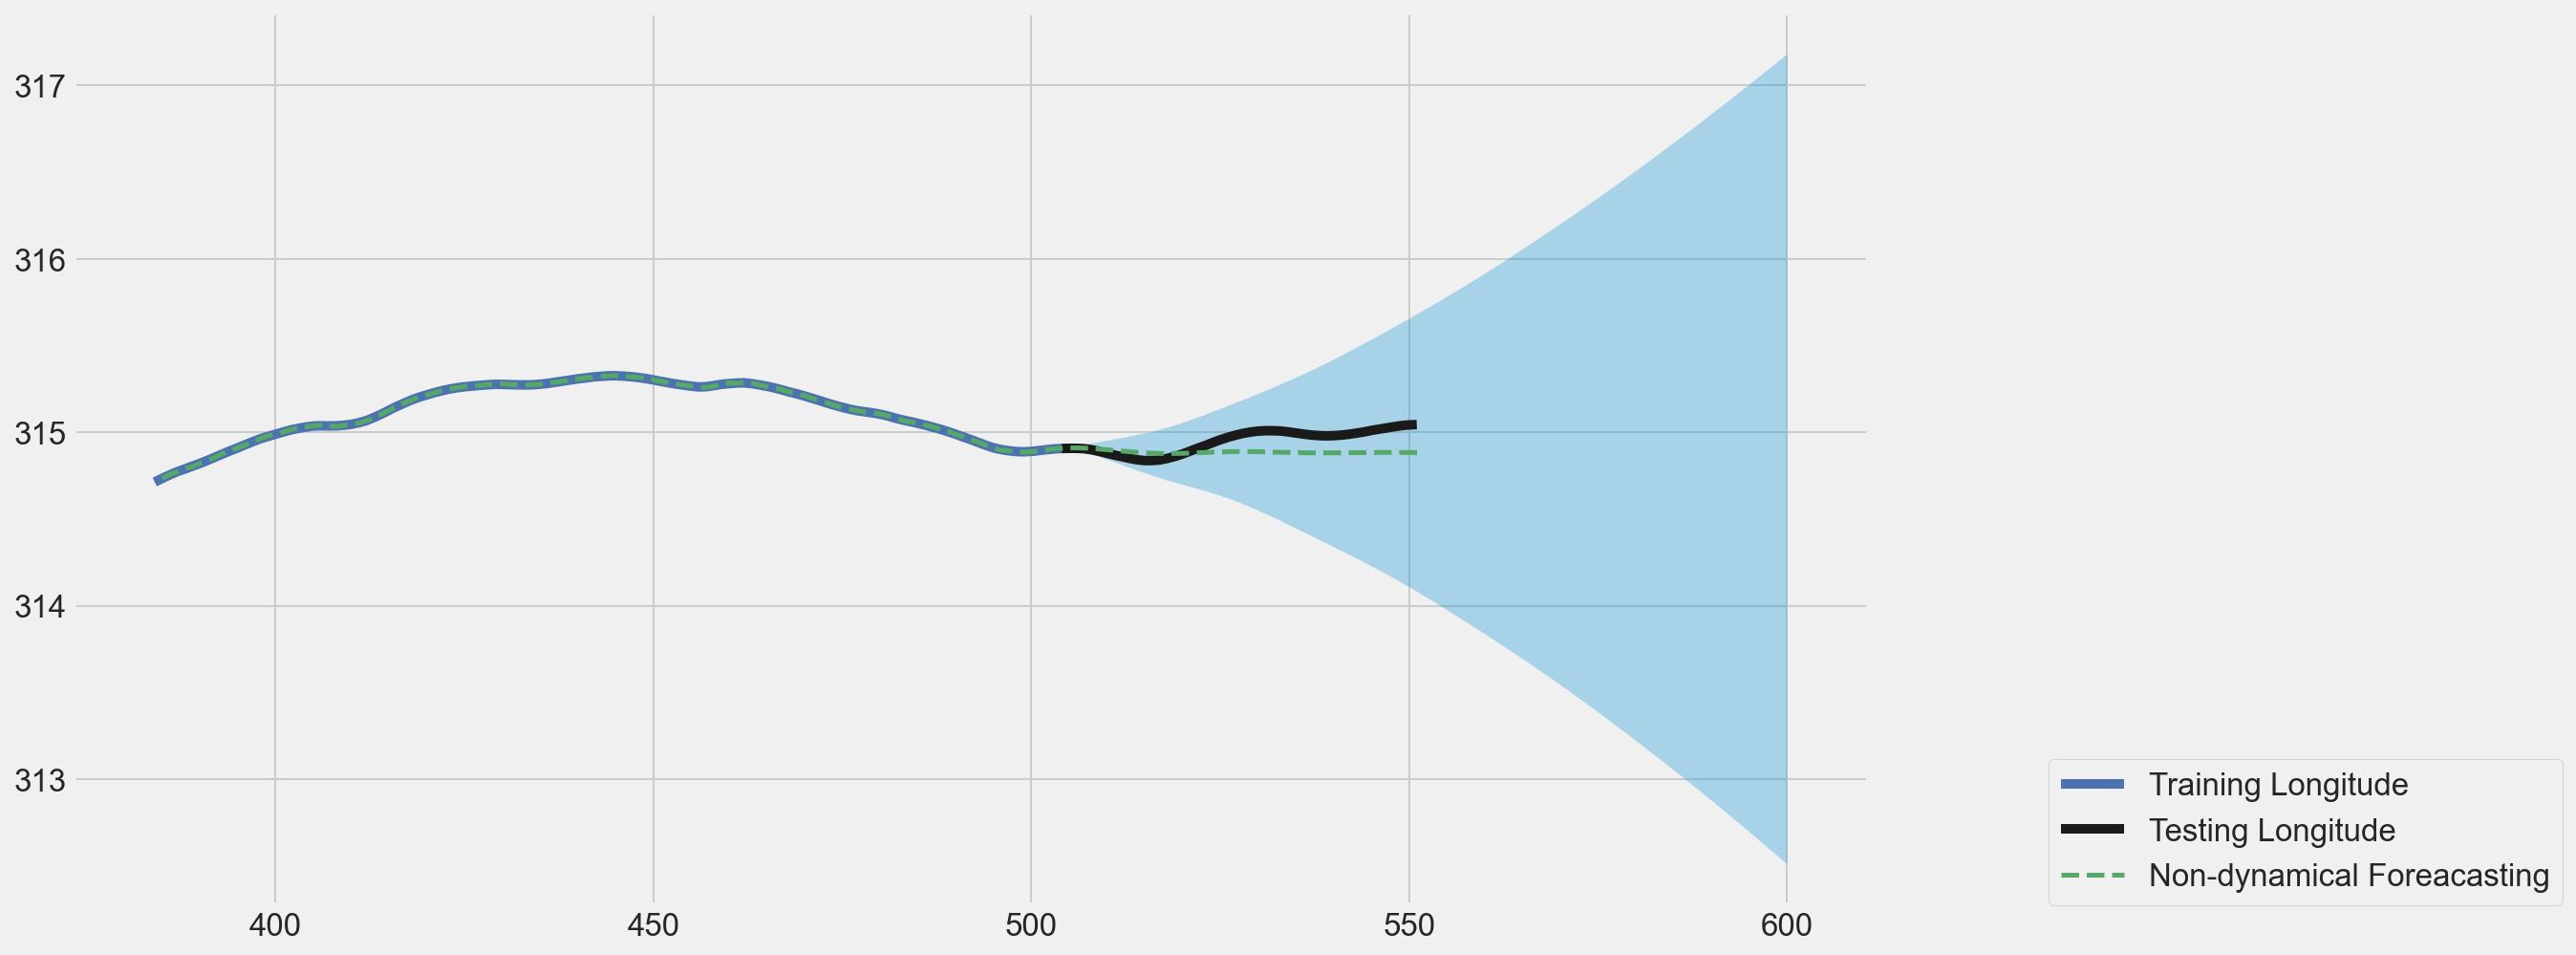

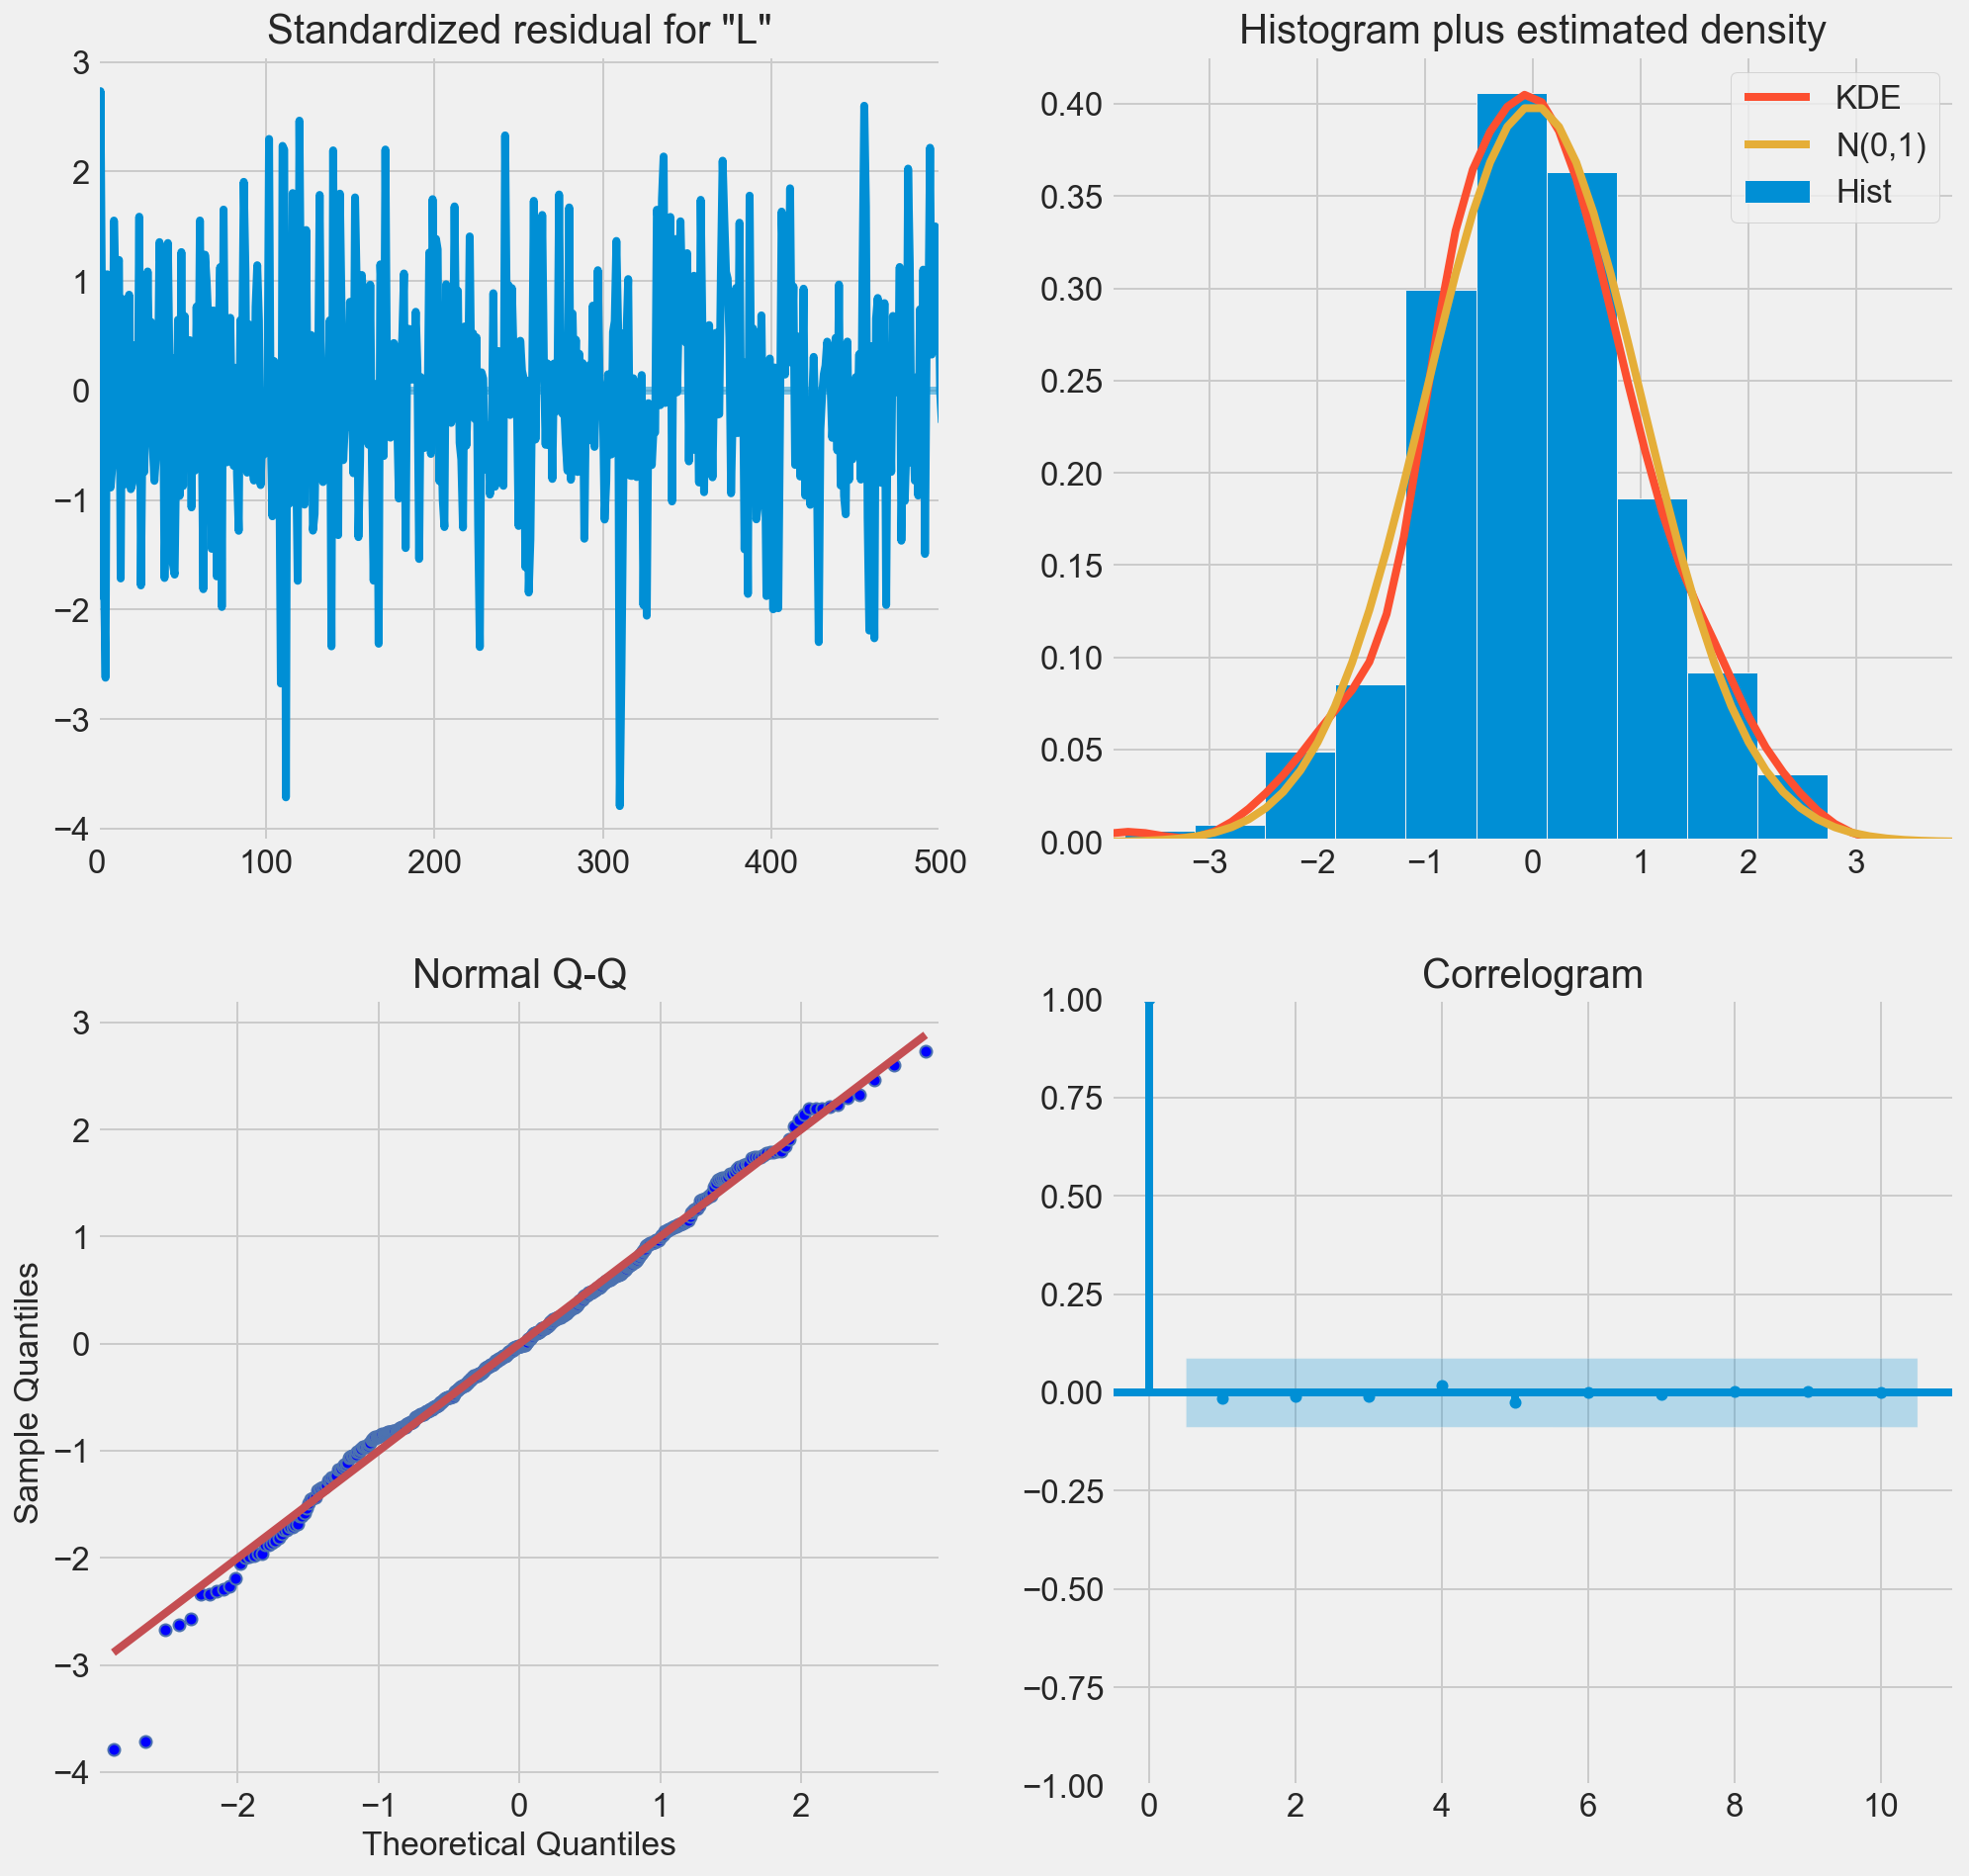

In [14]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(26, 2, 4),
                     start_p=24, end_p=48, exog_features=[])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  504
Model:              SARIMAX(26, 2, 4)   Log Likelihood                2538.392
Date:                Thu, 25 Nov 2021   AIC                          -5010.785
Time:                        14:16:47   BIC                          -4871.571
Sample:                             0   HQIC                         -4956.167
                                - 504                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1.629e-05   9.52e-05     -0.171      0.864      -0.000       0.000
Peak Direction  1.784e-07    4.9e-07      0.364      0.716   -7.83e-07    1.14e-06
ar.L1              0.2577      1.074

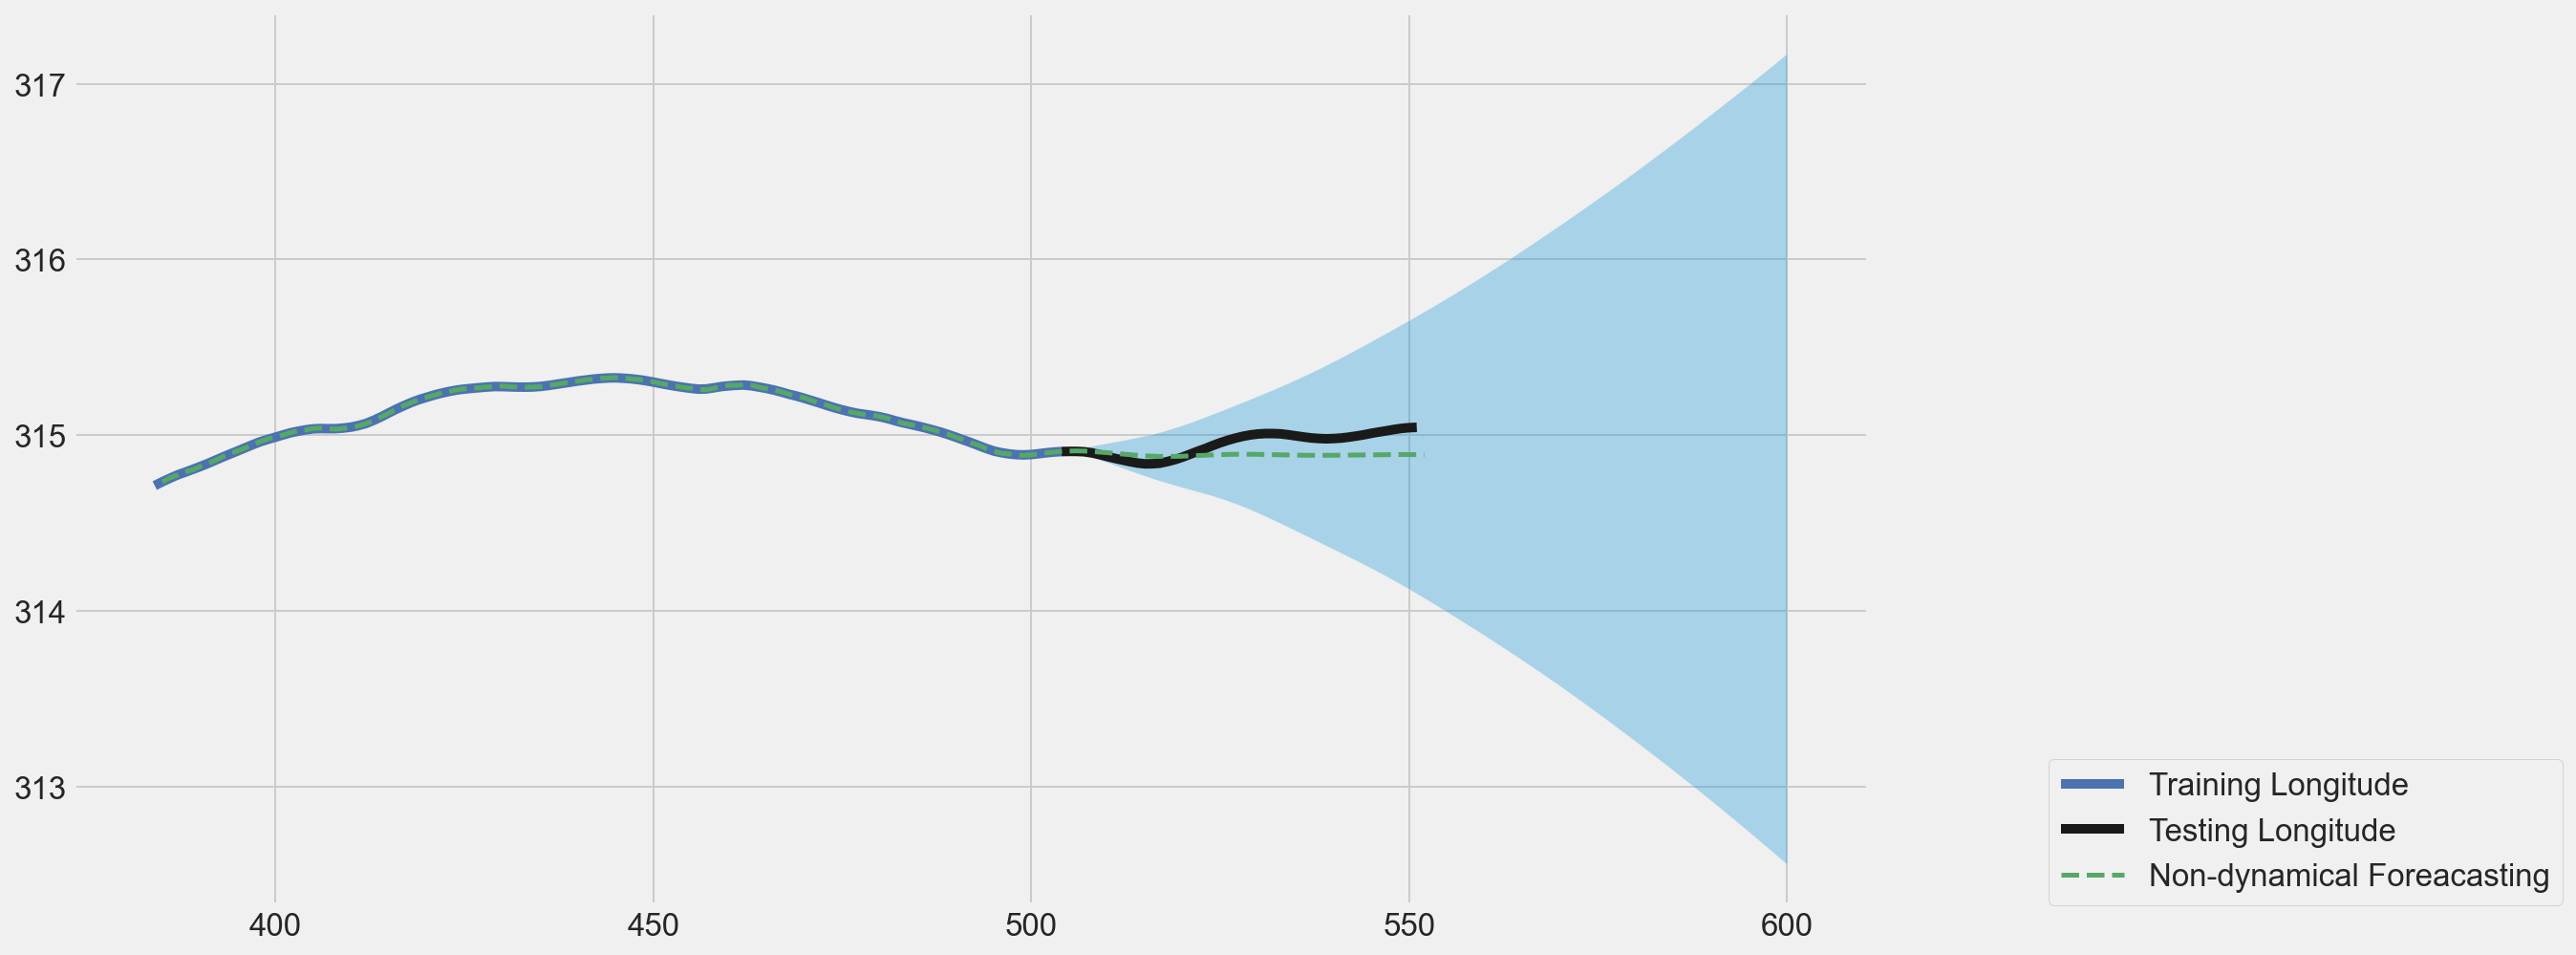

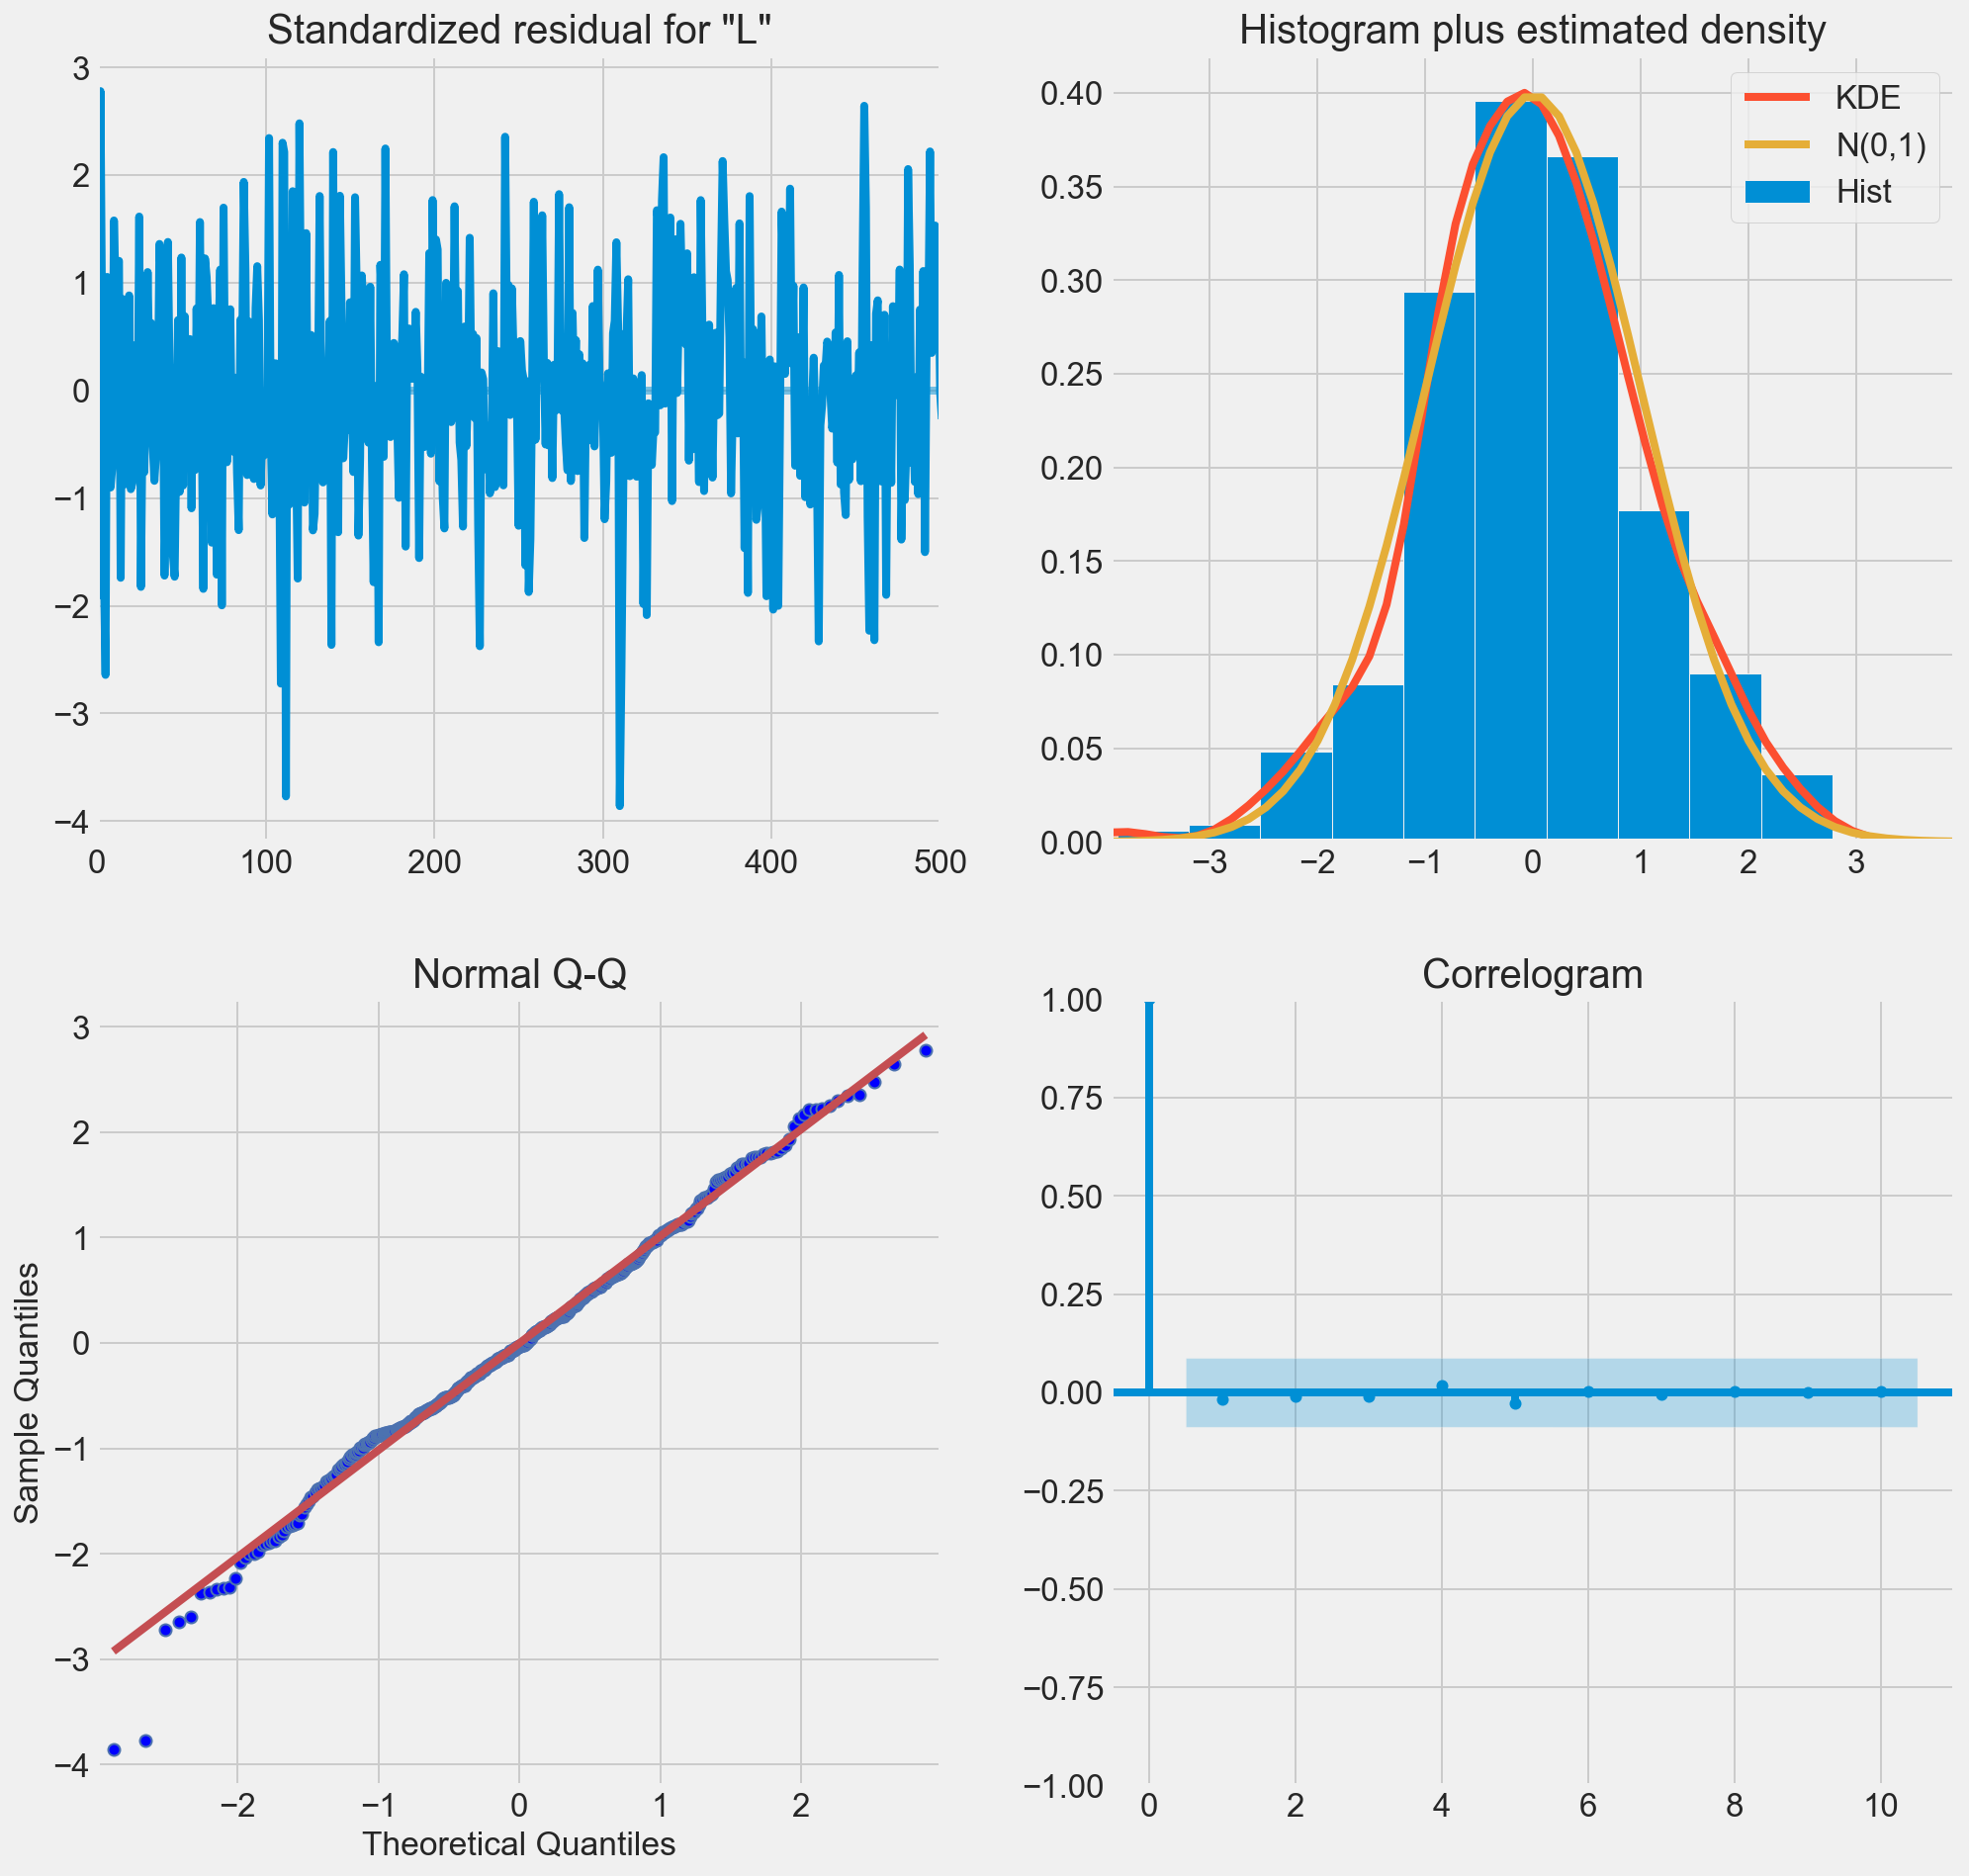

In [15]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(26, 2, 4),
                     start_p=24, end_p=48, exog_features=['Peak Direction'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  504
Model:              SARIMAX(36, 2, 4)   Log Likelihood                2543.476
Date:                Thu, 25 Nov 2021   AIC                          -4998.952
Time:                        14:16:56   BIC                          -4813.334
Sample:                             0   HQIC                         -4926.128
                                - 504                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept               -1.235e-05    9.8e-05     -0.126      0.900      -0.000       0.000
Significant Wave Height    -0.0003      0.000     -0.639      0.523      -0.001       0.001


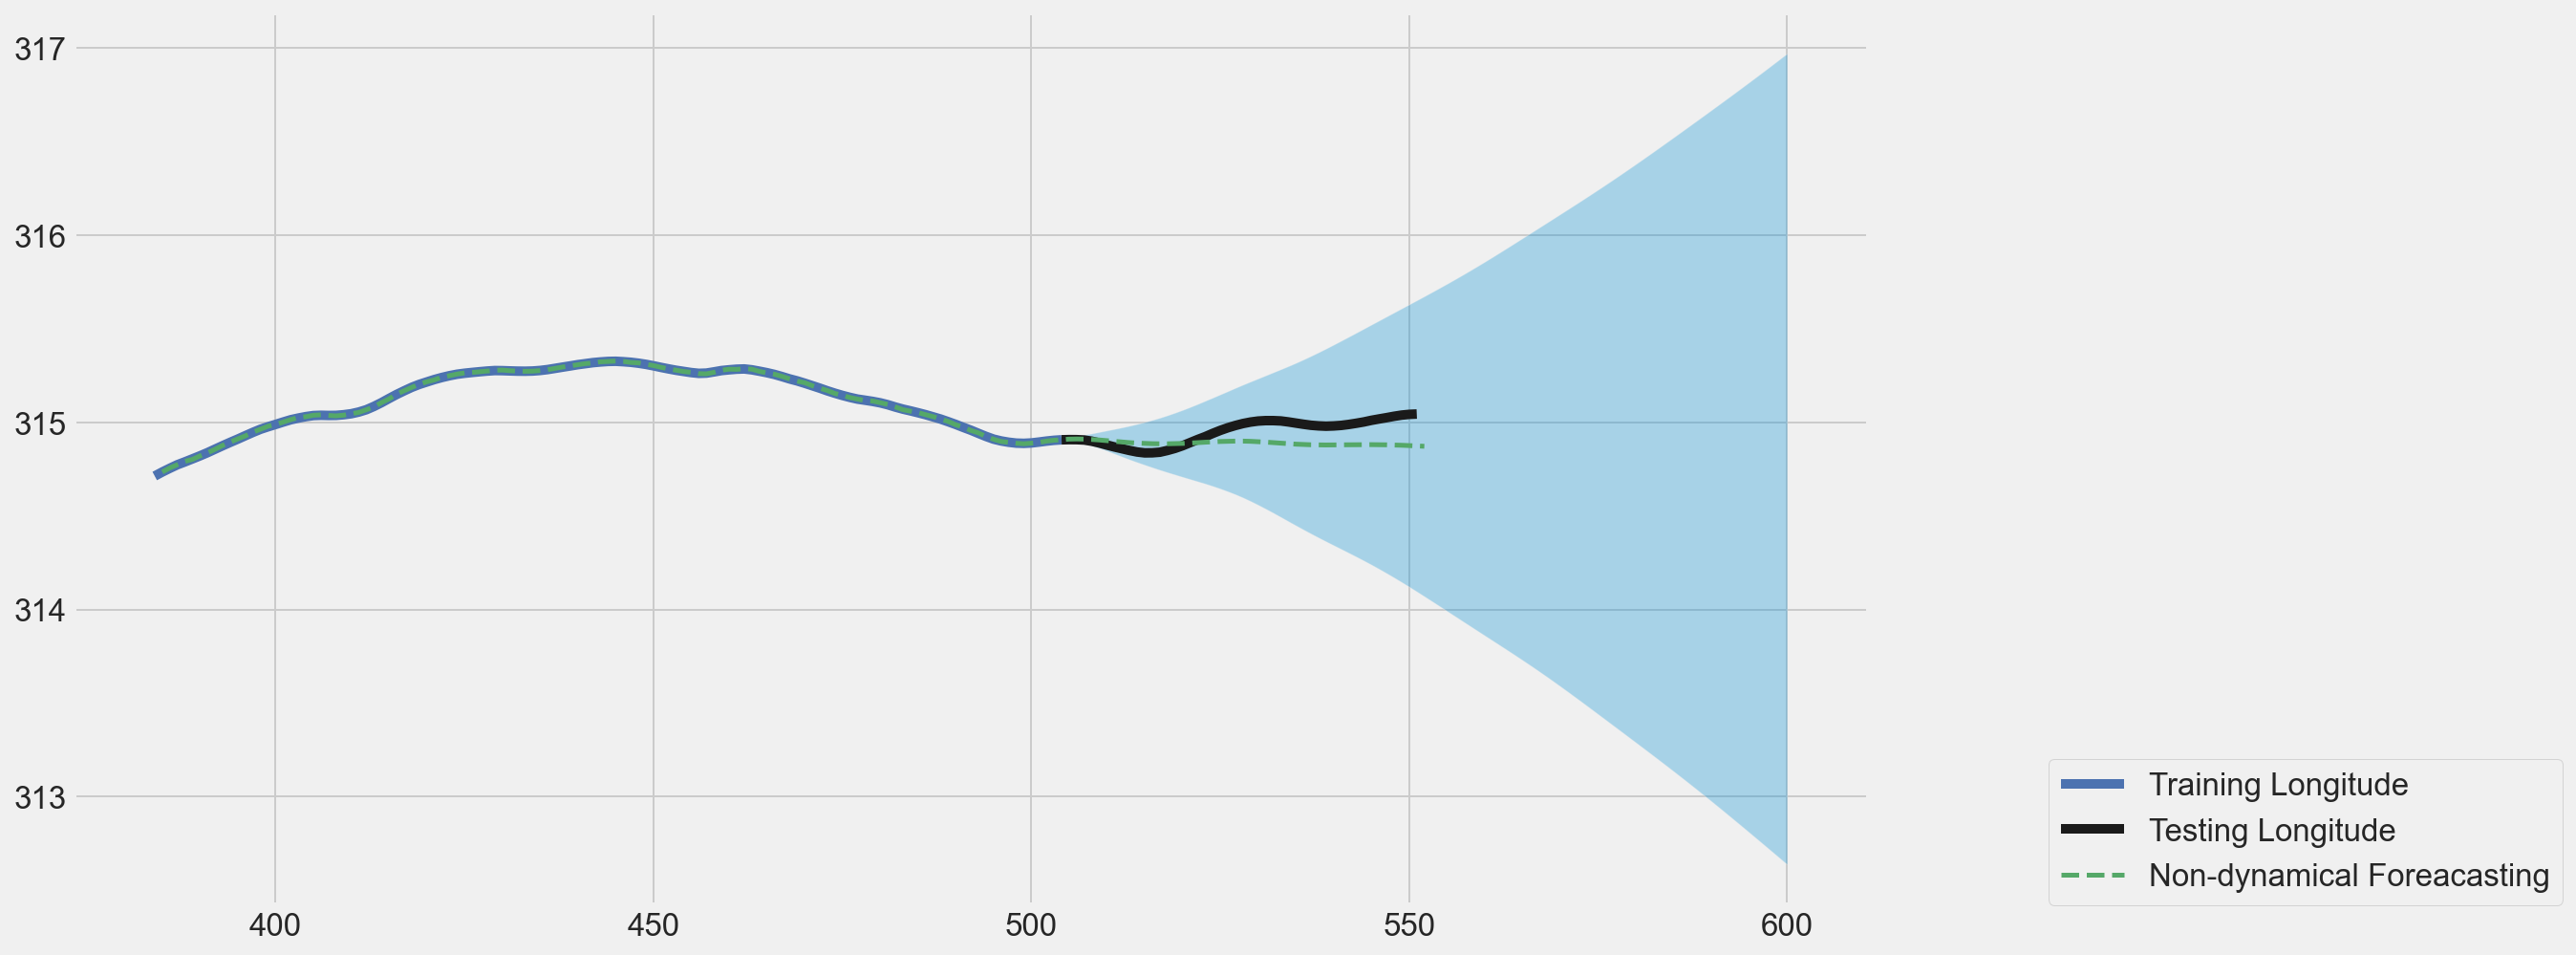

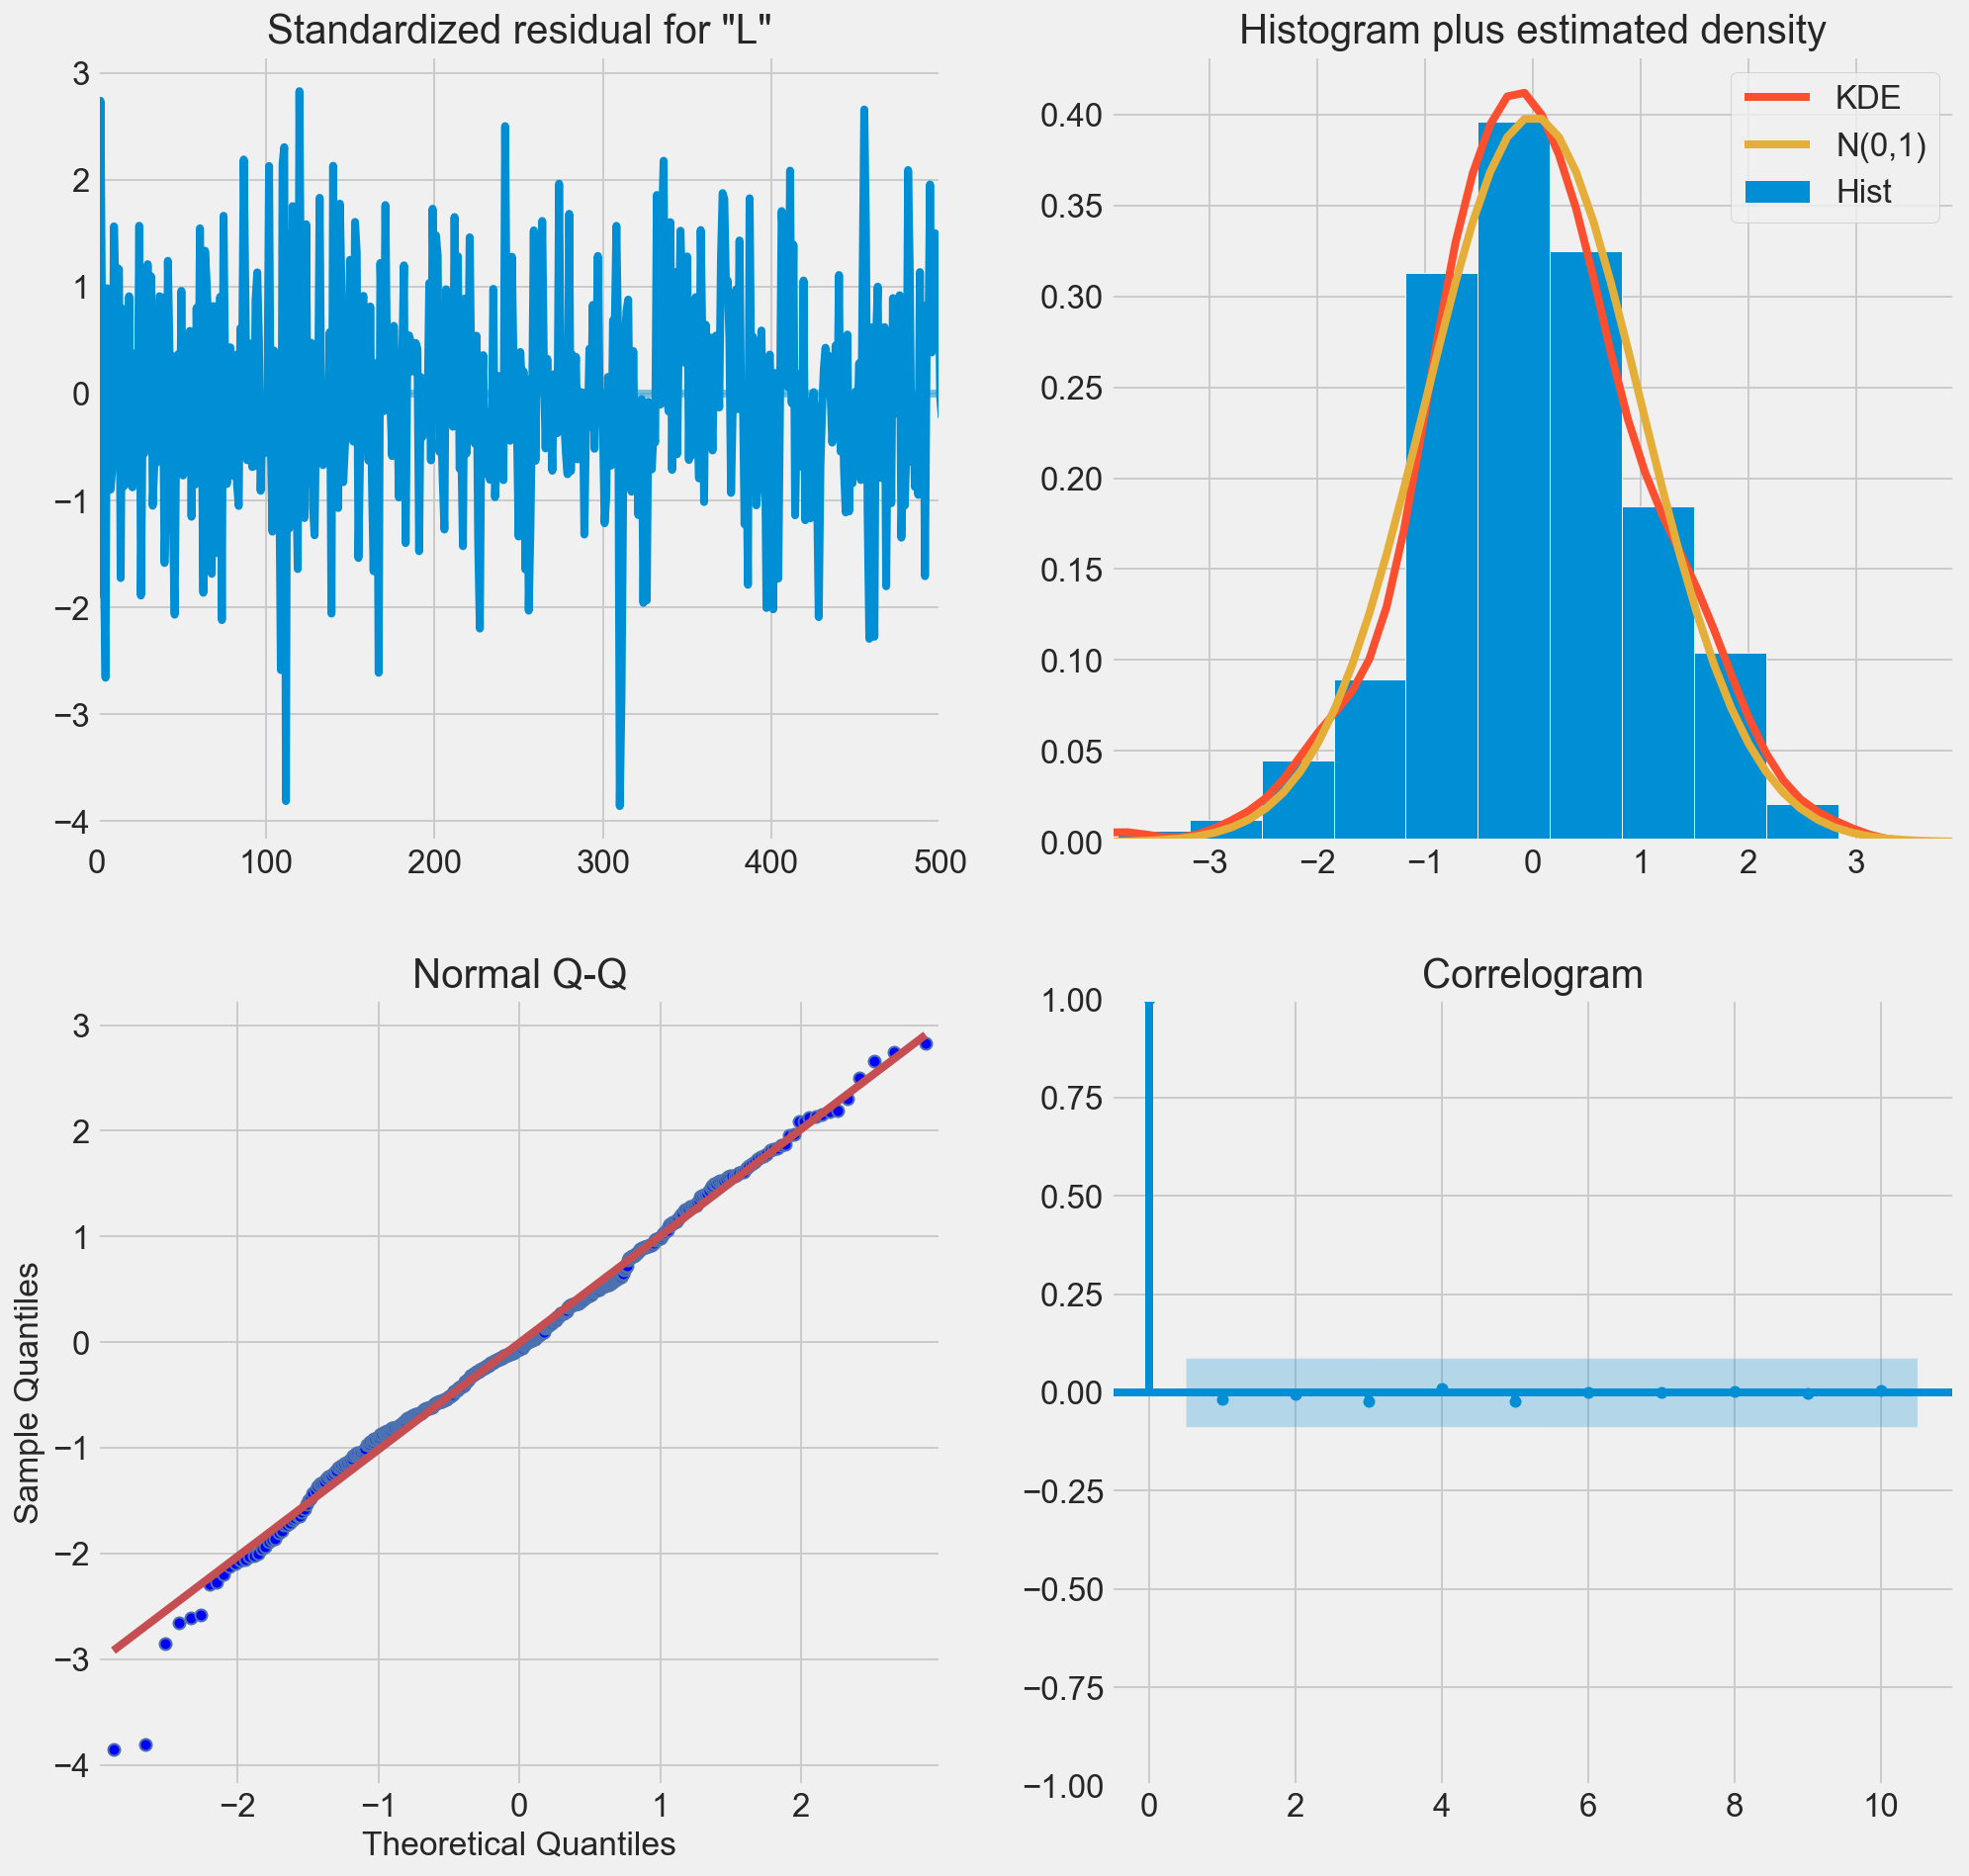

In [16]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(36, 2, 4),
                     start_p=24, end_p=48, exog_features=['Significant Wave Height', 'Peak Direction'])